##  .

**ABOUT CONFIGS**:
If we change them we should make sure that the behaviour is kept with the default arguments. When we pickle_load a config that has changed, the attributes that were not in it (because we may have changed the dataclass definition) are filled in automatically.

If a big change is done, maybe it's better to **create a new config with a different name**!

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
BASE_DIR = '/content/drive/My Drive/thesis1/'
SOURCE_DIR = BASE_DIR + 'src'
sys.path.append(SOURCE_DIR)
%cd {BASE_DIR}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/thesis1


In [ ]:
import numpy as np
import numpy.random as rd
import sklearn as sk
from sklearn.model_selection import train_test_split
import random
import pandas as pd
import os
import pickle
import copy

import time
import string
from datetime import date, datetime
from typing import Union, List, Tuple
from dataclasses import dataclass, astuple, asdict, replace
import pytz
import warnings
from collections import namedtuple, deque, OrderedDict
from pprint import pprint
from itertools import product
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms # tirar depois
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

from utils import get_trainable, discretize, hamming_loss, plot_character, add_subplot_border, plot_font
# from dataset import FontsDataset
# from model import EnergyNet

In [ ]:
# Notebook and general PyTorch Options

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'none' #  'all', 'last', 'last_expr', 'none', 'last_expr_or_assign'

blue_mod = '#1776cf'
red_mod = '#ff1500'

np.set_printoptions(precision=4, linewidth=500)
plt.rcParams['figure.figsize'] = [9, 6]

pd.options.display.max_rows = 5

# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda', 'Problem with GPU!'

In [ ]:
class boostedLoss(nn.Module):
    '''change the name
    Não sei porque é que não está a funcionar muito bem usando esta loss.

    
    if c > 1 increases the value of optimizing for the hidden masks'''

    def __init__(self, loss, c):
        super(boostedLoss, self).__init__()
        self.loss = loss
        self.c = c

    def forward(self, y, y_, letter_masks):
        # print(y.device, y_.device, letter_masks.device, n_masked.device, n_not_masked.device)~
        n_not_masked = (letter_masks).sum().detach()
        n_masked = (~letter_masks).sum().detach()
        loss_not_masked = self.loss(y[letter_masks], y_[letter_masks])
        loss_masked = self.loss(y[~letter_masks], y_[~letter_masks])
        output = n_not_masked*loss_not_masked + self.c*n_masked*loss_masked
        output = output / (n_not_masked + self.c*n_masked)
        return output

In [ ]:
boostedBCE = boostedLoss(nn.BCEWithLogitsLoss(), 1)

### Pickle and Checkpoints

In [ ]:
def pickle_dump(object, filename, save_dir=None, full_path=False):

    if full_path:
        save_dir = ''
    else:
        # By default saves to the pickle directory
        if save_dir is None:
            save_dir = BASE_DIR + 'pickle/'
        else:
            save_dir = BASE_DIR + save_dir

    with open(save_dir + filename, 'wb') as f:
        pickle.dump(object, f)

def pickle_load(filename, save_dir=None, full_path=False):

    if full_path:
        save_dir = ''
    else:
        # By default loads from the pickle directory
        if save_dir is None:
            save_dir = BASE_DIR + 'pickle/'
        else:
            save_dir = BASE_DIR + save_dir

    with open(save_dir + filename, 'rb') as f:
        return pickle.load(f)

In [ ]:
def extract_model_from_checkpoint(checkpoint, model=None, optimizer=None, 
                                  best_or_last_model='best', 
                                  load_instances_or_state='instances', 
                                  send_to_cuda=True, eval=True):
    
    # check out how to use a losslogger = checkpoint['losslogger']
    if not best_or_last_model in ['best', 'last']:
        raise Exception('You must choose either the best or the last model!')
    if not load_instances_or_state in ['instances', 'state']:
        raise Exception('You must choose to get the instances returned, or the '
                        'model and optimizer updated with the saved state!')
    
    if load_instances_or_state == 'instances':
        if best_or_last_model == 'best':
            model = checkpoint['best_model']
            optimizer = checkpoint['best_optimizer']
        else:
            model = checkpoint['last_model']
            optimizer = checkpoint['last_optimizer']
        return model, optimizer
    else:
        # if load_instances_or_state is state, just change the state of model and optimizer
        assert model is not None and optimizer is not None
        if best_or_last_model == 'best':
            model.load_state_dict(checkpoint['best_model_state_dict'])
            optimizer.load_state_dict(checkpoint['best_optimizer_state_dict'])
        else:
            model.load_state_dict(checkpoint['last_model_state_dict'])
            optimizer.load_state_dict(checkpoint['last_optimizer_state_dict'])   
    
    if send_to_cuda:
        model.to('cuda')
    if eval:
        model.eval()
    
    if load_instances_or_state == 'instances':
        return model, optimizer

def save_checkpoint(file_name, save_dir=None, best_model=None, last_model=None,
                    best_optimizer=None, last_optimizer=None, to_save='everything',
                    send_to_cpu=False, full_path=False, **kwargs):
    '''We can save the best_model, last_model, best_optimizer, last_optimizer, 
    and as kwargs the best_epoch, last_epoch, minimum_loss, batch_size, comments
    (a string with extra notes), etc.
    If save_dir is None, it will default to add the directory pickle to BASE_DIR
    By default, we send to CPU because it's safer this way I think
    '''

    def add_pytorch_model_or_optim_to_checkpoint(pytorch_object, object_name, to_save):
        nonlocal checkpoint
        if to_save not in ['everything', 'only_model', 'only_state_dict']:
            raise TypeError('to_save must indicate whether to save the module,'
                            ' only the state_dict, or both!')
        if send_to_cpu and isinstance(pytorch_object, torch.optim.Optimizer):
            raise TypeError("send_to_cpu doesn't apply for Optimizer objects!")

        if to_save == 'everything':
            if isinstance(pytorch_object, nn.Module) and send_to_cpu:
                checkpoint[object_name] = pytorch_object.to('cpu')
            else:
                checkpoint[object_name] = pytorch_object
            checkpoint[object_name+'_state_dict'] = pytorch_object.state_dict()
        elif to_save == 'only_model':
            if isinstance(pytorch_object, nn.Module) and send_to_cpu:
                checkpoint[object_name] = pytorch_object.to('cpu')
            else:
                checkpoint[object_name] = pytorch_object
        elif to_save == 'only_state_dict':
            checkpoint[object_name+'_state_dict'] = pytorch_object.state_dict()

    checkpoint = {}
    if best_model is not None:
        add_pytorch_model_or_optim_to_checkpoint(best_model, 'best_model', to_save)
    if last_model is not None:
        add_pytorch_model_or_optim_to_checkpoint(last_model, 'last_model', to_save)
    if best_optimizer is not None:
        add_pytorch_model_or_optim_to_checkpoint(best_optimizer, 'best_optimizer', to_save)
    if last_optimizer is not None:
        add_pytorch_model_or_optim_to_checkpoint(last_optimizer, 'last_optimizer', to_save)
    checkpoint.update(kwargs)

    if full_path:
        save_dir = ''
    else:
        # By default loads from the pickle directory
        if save_dir is None:
            save_dir = BASE_DIR + 'checkpoints/'
        else:
            save_dir = BASE_DIR + save_dir
    
    torch.save(checkpoint, save_dir + file_name)


def load_checkpoint(file_name, save_dir=None, full_path=False):

    if full_path:
        save_dir = ''
    else:
        # By default loads from the pickle directory
        if save_dir is None:
            save_dir = BASE_DIR + 'checkpoints/'
        else:
            save_dir = BASE_DIR + save_dir
    
    full_path_to_file = save_dir + file_name

    if os.path.isfile(full_path_to_file):
        checkpoint = torch.load(full_path_to_file)
        return checkpoint
    else:
        raise Exception("This path doesn't correspond to any file!")

### Dataset

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    '''To configure a Dataset, set those parameters below.

    It's not exactly necessary, but is helpful to have the configuration
    as a dataclass (Google Colab still doesn't type check anything though.)
    '''

    batch_size: int
    dataset_mode: str
    n_visible_letters: Union[None, int] = None
    prob_choice: Union[None, float] = None
    initial_seed: int = 48

    def __post_init__(self):
        # With Google Colab we can't easily use type hints, so we add this
        if self.dataset_mode not in ['fixed', 'mixed', 'prob'] or not isinstance(self.batch_size, int):
            raise ValueError

    def __iter__(self):
        return iter(astuple(self))

    def print_training_repr(self):
        output = f'Dataset Config: batch_size: {self.batch_size} • mode: '
        if self.dataset_mode == 'fixed':
            print(output + f'fixed • n_visible_letters: {self.n_visible_letters}')
        elif self.dataset_mode == 'mixed':
            print(output + f'mixed')
        elif self.dataset_mode == 'prob':
            print(output + f'prob • prob_choice: {self.prob_choice}')

In [ ]:
N_LETTERS = 26  # tirar daqui, precisa de estar também no modulo que chama. E não devia estar hardcoded

class FontsDataset(Dataset):
    def __init__(self, data, dataset_config):
        # y is the (unmasked) output. We'll need to construct the masked input

        _, dataset_mode, n_visible_letters, prob_choice, initial_seed = dataset_config

        if dataset_mode not in ['fixed', 'mixed', 'prob']:
            raise ValueError("the variable mode must be one of the following: "
                             "'fixed', 'mixed', 'prob'")

        # Data input and self.letter_masks are expected to be a pandas dataframe
        self.y = data.y.values.tolist()
        # Cuidado com as masks, pode ser lista de Nones?
        if self.y[0].shape[0] != N_LETTERS:
            raise ValueError
        self.n_fonts = len(self.y)

        # Here we build a random number generator for each dataset, which adds to
        # the ease of reproducilibity

        self.init_rngs(initial_seed)

        self.build_masked_input(dataset_config)
    
    def __len__(self):
        return self.n_fonts
  
    def __getitem__(self, index):
        # É mais rápido transformar em tensor e float aqui ou dentro da rotina das features?
        return torch.tensor(self.x[index]), torch.tensor(self.y[index]), self.letter_masks[index]

    def init_rngs(self, seed):
        self.rng = random.Random(seed)
        self.np_rng = rd.default_rng(seed)
    
    def get_rngs_states(self):
        return self.rng.getstate(), self.np_rng.bit_generator.state
    
    def set_rngs_states(self, states):
        self.rng.setstate(states[0])
        self.np_rng.bit_generator.state = states[1]

    def set_seed(self, seed):
        # What exactly does this do?
        # Different modules are used when the probability is used vs. when a fixed n_visible_letters is used
        # therefore, when we call set_seed we set both seeds.
        # Torch.manual_seed will set the seed for the data loader, fixing the order the different fonts are
        # loaded in shuffle mode.
        self.rng.seed(seed)
        self.np_rng = rd.default_rng(seed)

    def new_letter_masks_with_prob(self, n_fonts, prob_choice):
        # prob_choice is the probability of a certain character NOT being masked
        
        assert isinstance(n_fonts, int) and isinstance(prob_choice, float) 
        
        letter_masks = self.random_choice_at_least_one(n_fonts, prob_choice)
        letter_masks = list(letter_masks.astype(bool))
        return letter_masks

    def new_letter_masks_fixed(self, n_fonts, n_visible_letters):
        
        assert isinstance(n_fonts, int) and isinstance(n_visible_letters, int)
        assert 1 <= n_visible_letters <= 25

        letter_masks = np.concatenate([np.ones((n_fonts, n_visible_letters), dtype=bool),
                                       np.zeros((n_fonts, N_LETTERS-n_visible_letters), dtype=bool)],
                                      axis=1)
        
        for one_font_of_letter_masks in letter_masks:
            self.np_rng.shuffle(one_font_of_letter_masks)

        return letter_masks

    def new_letter_masks_mixed(self, n_fonts):
        
        letter_masks = []

        for i in range(n_fonts):
            random_n_letters = self.rng.randint(1, N_LETTERS-1)
            letter_mask = np.concatenate([np.ones(random_n_letters, dtype=bool),np.zeros(N_LETTERS - random_n_letters, dtype=bool)])
            self.np_rng.shuffle(letter_mask)
            letter_masks.append(letter_mask)
        
        return letter_masks

    def build_masked_input(self, dataset_config, another_seed=None, letter_masks=None):
        '''Generate a masked input of the letters for each font, according to
        the dataset_mode chosen. Each letter is masked by a list 'letter_masks', 
        which is generated by other functions. This masks are used to modify
        the input, so that only the letters corresponding to a True value in the
        mask are shown.
        We can also pass another_seed that may be different from the one passed
        in the beginning.
        '''

        # Describe possible modes in the doc string!
		
        _, dataset_mode, n_visible_letters, prob_choice, _ = dataset_config
        
        if dataset_mode not in ['fixed', 'mixed', 'prob']:
            raise ValueError("the variable dataset_mode must be one of the following: "
                             "'fixed', 'mixed', 'prob'")
        
        if another_seed is not None:
            self.set_seed(another_seed)

        # Generate letter_masks depending on the dataset_mode, or get them from a parameter
        if letter_masks is None:
            if dataset_mode == 'fixed':
                if n_visible_letters is not None:
                    self.letter_masks = self.new_letter_masks_fixed(self.n_fonts, n_visible_letters)
                    self.n_visible_letters = n_visible_letters
                else:
                    raise ValueError
            
            elif dataset_mode == 'mixed':
                self.letter_masks = self.new_letter_masks_mixed(self.n_fonts)

            elif dataset_mode == 'prob':
                if prob_choice is not None:
                    self.letter_masks = self.new_letter_masks_with_prob(self.n_fonts, prob_choice)
                    self.prob_choice = prob_choice
                else:
                    raise ValueError
        else:
            self.letter_masks = letter_masks
        
        if len(self.letter_masks) != self.n_fonts:
            raise ValueError('The number of fonts and masks for them is not the same!')

        # Generate a masked input, using the given letter_masks 
        self.x = [None]*self.n_fonts
        for font_index in range(self.n_fonts):
            self.x[font_index] = np.zeros((N_LETTERS, *LETTER_SHAPE), dtype=np.float32) + 0.5
            for letter_index in range(N_LETTERS):
                if self.letter_masks[font_index][letter_index] == True:
                    self.x[font_index][letter_index] = self.y[font_index][letter_index]


    def random_choice_at_least_one(self, n_fonts, prob_choice):
        '''Choose one letter per font randomly, and choose the others ones with
        probability equal to prob_choice. Therefore, choosing prob_choice=0.0
        will select only one letter per font. We do this because we want at
        least one letter per font to be shown during training or testing.
        '''

        def choose_mask(i, random_letter, prob_choice):
            if self.rng.random() < prob_choice or i == random_letter:
                return True
            else:
                return False
       
        letter_masks = []
        for font in range(n_fonts):
            random_letter = self.rng.randint(0, N_LETTERS-1)
            letter_mask = np.array([choose_mask(i, random_letter, prob_choice) for i in range(N_LETTERS)])
            letter_masks.append(letter_mask)

        return np.array(letter_masks)

    def get_letter_masks(self):
        if self.letter_masks is not None:
            return self.letter_masks
        else:
            raise Exception("No font masks were created yet!")

In [ ]:
# Construct datasets

N_LETTERS = 26 
y_ = pickle_load('y32.dat')
assert N_LETTERS == len(y_[0])

SIDE_SIZE_PIXELS = y_[0][0].shape[0]
LETTER_SHAPE = (SIDE_SIZE_PIXELS, SIDE_SIZE_PIXELS)
FONT_SHAPE = (N_LETTERS, *LETTER_SHAPE)
N_PIXELS_PER_CHARACTER = SIDE_SIZE_PIXELS**2

fonts = pd.DataFrame({'y': y_}, index=range(len(y_)))

# Não fazer hard-code das percentagens de tamanaho para cada dataset e tornar mais
# intuitivo o que se está a fazer nas linhas em que se usa train_test_split.
# test_share_size = 1/6
# valid_share_size = 1/6
train_data, test_data = train_test_split(fonts, test_size=1/6, random_state=48)
train_data, valid_data = train_test_split(train_data, test_size=1/5, random_state=49)

average_of_letter = np.zeros(FONT_SHAPE)
for _, y in train_data.iterrows():
    average_of_letter += y[0]
average_of_letter /= len(train_data)

average_of_letter = np.expand_dims(average_of_letter, axis=0)
# TO_COMMENT: why do we do it this way?
average_of_letter = np.repeat(average_of_letter, repeats=max(len(train_data), len(valid_data), len(test_data)), axis=0)
average_of_letter = torch.tensor(average_of_letter, dtype=torch.float32)
average_of_letter_for_init = average_of_letter - 0.5

### Test Dataset / Algorithm

In [ ]:
def plot_font(x, letter_masks=None, mode='1_row', to_show=True, to_save=False, save_dir=None, filename=None):

    if to_save and (save_dir is None or filename is None):
        raise Exception('Introduce a valid directory and filename!')

    if mode == '4_rows':
        fig, axs = plt.subplots(4, 7, figsize=(8, 8*4/7))
        shape = x[0].shape
        index = 0
        for i in range(4):
            j = 0
            while j < 7:
                axs[i, j].set_axis_off()
                skip_plot = i != 3 or j != 0
                if skip_plot and index < 26:
                    axs[i, j].imshow(x[index], cmap='Greys', norm=plt.Normalize(0., 1.))
                    index += 1
                j += 1
        
    elif mode == '2_rows':
        fig, axs = plt.subplots(2, 13, figsize=(15, 15*2/13))
        shape = x[0].shape
        index = 0
        for i in range(2):
            for j in range(13):
                axs[i, j].set_axis_off()
                if index < 26:
                    axs[i, j].imshow(x[index], cmap='Greys', norm=plt.Normalize(0., 1.))
                index += 1

    elif mode == '1_row':
        fig, axs = plt.subplots(1, len(x), figsize=(24, 24))
        for i, ax in enumerate(axs):
            ax.set_axis_off()
            ax.imshow(x[i], cmap='Greys', norm=plt.Normalize(0., 1.))
            if letter_masks is not None and letter_masks[i] == 1:
                add_subplot_border(ax, width=2, color='red')
    else:
        raise Exception(f'The mode "{mode}" doesn\'t exist!')
    plt.setp(axs, xticks=[], yticks=[])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    if to_save:
        plt.savefig(save_dir + filename + '.png', dpi=200, format='png', bbox_inches='tight')
    if to_show:
        plt.show()
    else:
        # this closes the figure, preventing it from being shown by the notebook
        # (which we might want if we want to produce a lot of pictures)
        plt.close(fig)

In [ ]:
# dataset_config = DatasetConfig(batch_size=180, dataset_mode='fixed', n_visible_letters=10)
# train_dataset = FontsDataset(train_data, dataset_config)
# train_dataloader = DataLoader(train_dataset, dataset_config.batch_size, shuffle=True, num_workers=0, pin_memory=True)

# # n_iter = 1
# # inner_lr = 10.

# # energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220), 
# #                           n_layers_per_conv_block = (2, 2, 3, 3),
# #                           kernel_sizes = (5, 5, 3, 3),
# #                           n_linear_features = (200, 80),  
# #                           dropout_probs = (0.3, 0.5))
# # energy_net = EnergyNet(energy_net_config_A)

# # criterion = nn.BCEWithLogitsLoss().to(device)
# # unroll_config_A = UnrollConfig(n_iter_inference=n_iter, inner_lr=inner_lr)
# # unrolled = UnrollEnergy(energy_net, criterion, unroll_config_A).to(device)

# # seed = 42
# # torch.manual_seed(seed)
# # train_dataset.build_masked_input(DatasetConfig(batch_size=dataset_config.batch_size, dataset_mode='prob', prob_choice=0.5))


# # # !!! Decidir se pôr em modo de eval ou training!
# # energy_net.eval()

# train_dataset.build_masked_input(dataset_config)
# for i, (x, y, letter_masks) in enumerate(train_dataloader):
#     x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
#     # for j in range(180):
#     #     plot_font(y[j].cpu(), mode='2_rows')
#     break
# #     # x = x[0:2]
# #     # y = y[0:2]
# #     # letter_masks = letter_masks[0:2]
# #     # logits = energy_net(x.unsqueeze(1))
# #     # energyA.to(device)
# #     # l = energyA(x)
# #     # y_ = discretize(torch.sigmoid(logits))[~letter_masks]

# #     # with torch.no_grad():
# #     #     e = energy_net(x.clone().detach())
# #     # l, loss = unrolled(x.clone().detach(), y[~letter_masks], letter_masks, inner_lr)
# #     # loss.backward()
# #     # grads = copy.deepcopy([p.grad for p in energy_net.parameters()])
# #     # # unrolled.zero_grad()

# #     # with torch.no_grad():
# #     #     y_ = discretize(torch.sigmoid(logits))[~letter_masks]
# #     break

In [ ]:
# Snippets for help with testing

# for n1, v2 in zip(energy_net.state_dict().keys(), energy_net_1.state_dict().values()):
#     energy_net.state_dict()[n1].copy_(v2)

# for (s1, v1), (s2, v2) in zip(energy_net.state_dict().items(), energy_net_1.state_dict().items()):
#     print(s1, s2, torch.all(v1 == v2).item())

# def print_min_max_abs_difference(x1, x2):
#     abs_difference = x1 - x2
#     print(f'min: {torch.min(abs_difference)} • max: {torch.max(abs_difference)}')

# Copy exact state dict from one energy_net to another with an arquitecture defined a different,
# but equivalent, way.
# for n1, v2 in zip(energy_net.state_dict().keys(), energy_net_1.state_dict().values()):
#     energy_net.state_dict()[n1].copy_(v2)

### Metrics

In [ ]:
# We are making the average for the iou / dice_coeff for each character!

def iou(y_, y):
    mask_y_ = (y_ == 1)
    mask_y = (y == 1)
    intersection = (mask_y_ & mask_y).sum((1, 2))
    union = (mask_y_ | mask_y).sum((1, 2))
    iou = torch.true_divide(intersection, union).mean()
    return iou.item()

def dice_coefficient(y_, y):
    mask_y_ = (y_ == 1)
    mask_y = (y == 1)
    numerator = 2*(mask_y_ & mask_y).sum((1, 2))
    denominator = (mask_y_ == 1).sum((1, 2)) + (mask_y == 1).sum((1, 2))
    dice_coeff = torch.true_divide(numerator, denominator).mean()
    return dice_coeff.item()

# Vale a pena criar uma classe aqui?

def init_running_metrics(metrics_names):
    metrics = {}
    for name in metrics_names:
        metrics[name] = 0.
    return metrics

def update_running_metrics(metrics, logits_missing, y_missing, letter_masks, 
                           total_n_missing_letters, loss=None, custom_loss=None, criterion=None):
    with torch.no_grad():
        batch_size_ = letter_masks.shape[0]
        n_missing_letters = (~letter_masks).sum().item()
        y_pred = discretize(torch.sigmoid(logits_missing))

        if 'bce_all' in metrics:
            assert loss is not None
            metrics['bce_all'] += loss.item()*batch_size_
        if 'bce' in metrics:
            metrics['bce'] += criterion(logits_missing, y_missing).item()*n_missing_letters
        if 'custom_bce' in metrics:
            assert custom_loss is not None
            metrics['custom_bce'] += custom_loss.item()*n_missing_letters
        if 'hamming' in metrics:
            metrics['hamming'] += hamming_loss(y_pred, y_missing)*n_missing_letters
        if 'iou' in metrics:
            # print(iou(y_pred, y_missing), n_missing_letters, iou(y_pred, y_missing)*n_missing_letters)
            metrics['iou'] += iou(y_pred, y_missing)*n_missing_letters
        if 'dice' in metrics:
            metrics['dice'] += dice_coefficient(y_pred, y_missing)*n_missing_letters
        if 'euclidian' in metrics:
            metrics['euclidian'] += torch.cdist(y_pred, y_missing)*n_missing_letters
        
        total_n_missing_letters += n_missing_letters

    return metrics, total_n_missing_letters


def compute_final_metrics(running_metrics, dataset_size, total_n_missing_letters):
    
    final = {}

    if 'bce_all' in running_metrics:
        final['bce_all'] = running_metrics['bce_all'] / dataset_size
    if 'bce' in running_metrics:
        final['bce'] = running_metrics['bce'] / total_n_missing_letters
    if 'custom_bce' in running_metrics:
        final['custom_bce'] = running_metrics['custom_bce'] / total_n_missing_letters
    if 'hamming' in running_metrics:
        final['hamming'] = running_metrics['hamming'] / total_n_missing_letters
    if 'iou' in running_metrics:
        final['iou'] = running_metrics['iou'] / total_n_missing_letters
    if 'dice' in running_metrics:
        final['dice'] = running_metrics['dice'] / total_n_missing_letters

    return final

### Utils

In [ ]:
def get_usual_energy_net_params(model):
    # TODO: Não criar lista de parametros, mas iterador
    ps = list(model.parameters())[0:36] + \
         list(model.parameters())[76:]
    return ps

def get_usual_energy_net_fc_params(model):
    # TODO: Não criar lista de parametros, mas iterador
    # It doesn't return the bias of the last linear layer in purpose
    # as this one will not not be involved in the derivatie
    ps = list(model.parameters())[76:]
    return ps

def get_usual_energy_net_named_params(model):
    # TODO: Não criar lista de parametros, mas iterador
    ps = list(energyNet.named_parameters())[0:36] + \
         list(energyNet.named_parameters())[76:]
    return ps

def get_usual_energy_net_named_fc_params(model):
    # TODO: Não criar lista de parametros, mas iterador
    ps = list(model.named_parameters())[76:]
    return ps

# def set_usual_energy_net_params(model, new_parameter_grads):
#     ps = list(model.parameters())[0:36] + list(model.parameters())[76:]
#     for i, p in enumerate(ps):
#         p.grad = new_parameter_grads[i]

eps = torch.finfo(torch.float32).eps

class AvoidZeroOne(nn.Module):
    def __init__(self):
        super(AvoidZeroOne, self).__init__()
    def forward(x):
        eps_tensor = torch.tensor(eps).expand(x.size()).to(device)
        x = torch.where(x==0., eps_tensor, x)
        x = torch.where(x==1., 1-eps_tensor, x)
        return x

def Histogram(a, bins=50, density=True, new_figure=True, figsize=(10,7), vals=False, *args, **kwargs):
    hist, bins = np.histogram(a, bins, density=density)
    bincenters = 0.5*(bins[1:] + bins[:-1])
    if new_figure:
        plt.figure(0, figsize=figsize)
    plt.plot(bincenters, hist, *args, **kwargs)
    if vals:
        return bincenters, hist

class Entropy(nn.Module):
    def __init__(self):
        super(Entropy, self).__init__()

    # This one would be the case if we'd have dimension 1 corresponding to the logits of a certain distribution 
    # def forward(self, logits):
    #     p_log_p = F.softmax(logits, dim=1) * F.log_softmax(logits, dim=1)
    #     h = - p_log_p.sum(dim=1)
    #     return h

    def forward(self, logits):
        n = logits.shape[0]
        p = AvoidZeroOne.forward(torch.sigmoid(logits))
        t = p*torch.log(p) + (1.-p)*torch.log(1.-p)
        h = -t.sum((1, 2))
        return h

entropy = Entropy()

class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()
    #Make differentiable!
    def forward(self, l):
        max_abs = torch.max(torch.abs(l))
        return l/max_abs
        
squeeze = Squeeze()

def create_hparams_dict(last_softplus, init_mode, n_iter_inference, entropy_factor, inner_lr, lr):
    hparams_dict = {'last_softplus': last_softplus,
                    'init_mode': init_mode,
                    'n_iter_inference': n_iter_inference,
                    'entropy_factor': entropy_factor,
                    'inner_lr': inner_lr,
                    'outer_lr': lr}
    return hparams_dict


def ask_add_epochs(default_n_epochs=5):
    valid_result = False
    while valid_result is not True:
        prompt = f'Press "c" to continue to the next probability setting.\n'\
                 f'You can also press Enter to add a new epoch, indicate how many epochs to add to this one, '\
                 f'or press "d" to add the default number of epochs ({default_n_epochs}).\n'
        r = input(prompt)   
        if r == 'd':
            r = str(default_n_epochs)
        if r.isnumeric():
            print(f'Add {int(r)} epoch(s)!')
            valid_result = True
            return int(r)
        elif r == '':
            print(f'Add 1 epoch!')
            return 1
        elif r == 'c':
            print('Continue!')
            return False
        else:
            print('Introduce a valid number of epochs!')

def probs_curriculum_learning(probs_choice, duration_learning):
    # duration_learning is the number of epochs for each probs_choice
    new_setting = True
    epoch = 1
    for setting_index, (prob_choice, n_epoch) in enumerate(zip(probs_choice, duration_learning)):
        j = 0
        while j < n_epoch:
            yield epoch, prob_choice, new_setting, setting_index
            new_setting = False
            if j == n_epoch - 1:
                try:
                    n_extra_epochs = ask_add_epochs()
                    if type(n_extra_epochs) is int:
                        n_epoch += n_extra_epochs
                    if n_extra_epochs == False:
                        new_setting = True
                        pass
                except EOFError:
                    new_setting = True
                    pass
            j += 1
            epoch += 1

def print_header_scores():
    print(f'\nEpoch  |  Custom BCE   BCE (train)   BCE (valid)   IOU (train)   IOU (valid)  |  k_valid     k_train    Max valid IoU   Max train IoU')

# create dataclass for train_metrics?
def print_scores(epoch, train_metrics, valid_metrics, k_valid, k_train, max_valid_iou, max_train_iou):
    print(f"{epoch:<4}   |  {train_metrics['custom_bce']:.3f}        {train_metrics['bce']:.3f}         {valid_metrics['bce']:.3f}         "
            f"{100*train_metrics['iou']:.2f}         {100*valid_metrics['iou']:.2f}        |  {k_valid:<7}     {k_train:<7}    "
            f"{100*max_valid_iou:.2f}           {100*max_train_iou:.2f}")

def current_time():
    time_zone_PT = pytz.timezone('Europe/London')
    return datetime.now(time_zone_PT)

def current_time_repr():
    return current_time().strftime("%Y-%m-%d|%Hh%M")

def get_created_class_attributes(object_):
    return [a for a in dir(object_) if a[:2] != '__']

def print_mem():
    print('memory:', torch.cuda.memory_reserved()/(1024**3))

### Encoder Blocks


In [ ]:
def encoder_block(n_layers, in_channels, out_channels, kernel_size=3, use_batchnorm=False, use_softplus=True, beta=1.):
    "n_layers is the number of blocks of Conv2d + BackNorm2d + ReLU"
    padding = kernel_size // 2
    block = []
    for layer_index in range(n_layers):
        if layer_index > 0:
            in_channels = out_channels
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(out_channels))
        if use_softplus:
            block.append(nn.Softplus(beta))
        else:
            block.append(nn.ReLU())
    return nn.Sequential(*block)

def decoder_block(n_layers, in_channels, out_channels, kernel_size=3, out=False, use_batchnorm=False, use_softplus=True, beta=1.):
    "n_layers is the number of blocks of Conv2d + BackNorm2d + ReLU"
    padding = kernel_size // 2
    block = []
    out_channels_ = in_channels
    for layer_index in range(n_layers):
        if layer_index == n_layers-1:
            out_channels_ = out_channels 
        block.append(nn.ConvTranspose2d(in_channels, out_channels_, kernel_size=kernel_size, padding=padding))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(out_channels_))
        if out is False or layer_index != n_layers-1:
            if use_softplus:
                block.append(nn.Softplus(beta))
            else:
                block.append(nn.ReLU())
    return nn.Sequential(*block)

### EnergyNet

In [ ]:
@dataclass(frozen=True)
class EnergyNetConfig:
    '''To configure an Energy Network architecture, set those parameters below.

    It's not exactly necessary, but is helpful to have the configuration
    as a dataclass (Google Colab still doesn't type check anything though.)
    '''

    n_channels_conv: Tuple[int]
    n_layers_per_conv_block: Tuple[int]
    kernel_sizes: Tuple[int]
    n_linear_features: Tuple[int]
    dropout_probs: Tuple[float]
    use_batchnorm: bool = False
    beta: float = 1.
    last_softplus: bool = False
    use_softplus: bool = True

    def __post_init__(self):
        # With Google Colab we can't easily use type hints, so we add this
        if not (isinstance(self.n_channels_conv, tuple) and isinstance(self.n_layers_per_conv_block, tuple) and
            isinstance(self.kernel_sizes, tuple) and isinstance(self.n_linear_features, tuple) and
            isinstance(self.dropout_probs, tuple) and isinstance(self.use_batchnorm, bool) and
            isinstance(self.beta, float) and isinstance(self.last_softplus, bool) and
            isinstance(self.use_softplus, bool)):
            raise TypeError('The parameters must be of the given types!')
        if len(self.n_channels_conv) != len(self.n_layers_per_conv_block) or \
            len(self.n_layers_per_conv_block) != len(self.kernel_sizes):
            raise ValueError('n_channels_conv, n_layers_per_conv_block, and '
                              'kernel_sizes must have the same length!')
        if len(self.n_linear_features) != len(self.dropout_probs):
            raise ValueError('n_linear_features and dropout_probs must have the same length!')

    def __iter__(self):
        # Dataclass doesn't unpack by default
        # I could have written that:
        
        # return iter([self.n_channels_conv, self.kernel_sizes, self.n_features_fc,
        #             self.beta, self.use_softplus, self.last_softplus])
        return iter(astuple(self))

    def print_training_repr(self):
        print(f'EnergyNet Config: n_channels_conv: {self.n_channels_conv} • n_layers_per_conv_block: {self.n_layers_per_conv_block} • '
              f'kernel_sizes: {self.kernel_sizes}\n' + ' '*18 + f'n_linear_features: {self.n_linear_features} • '
              f'dropout_probs: {self.dropout_probs} • beta: {self.beta}')

In [ ]:
class EnergyNet(nn.Module):
    """Energy Net accepting a configuration object for defining the architecture
    
    TO DO: Maybe generalize for the other energy nets to be used."""

    # transformar todas as relus em softplus!
    def __init__(self, config, architecture='usual', beta_is_parameter=False):
        super(EnergyNet, self).__init__()
        
        if not isinstance(config, EnergyNetConfig):
            raise TypeError('One must insert a valid EnergyNetConfig!')

        self.architecture = architecture
        n_channels_conv, n_layers_per_conv_block, kernel_sizes, n_linear_features, \
        dropout_probs, use_batchnorm, beta, last_softplus, use_softplus = config
        n_conv_blocks = int(len(n_layers_per_conv_block))

        # self.beta = torch.tensor(beta, device=device)
        # if beta_is_parameter:
        #     self.beta = torch.nn.Parameter(self.beta)
        
        softplus = torch.nn.Softplus(beta)

        n_channels_conv = [N_LETTERS] + list(n_channels_conv)

        conv_modules = OrderedDict()
        # self.conv = nn.ModuleList()
        for i, (n_layers, kernel_size) in enumerate(zip(n_layers_per_conv_block, kernel_sizes)):
            # self.conv.append(encoder_block(n_layers, n_channels_conv[i], n_channels_conv[i+1], kernel_size, use_softplus, beta))
            conv_modules['encode_conv_' + str(i+1)] = encoder_block(n_layers, n_channels_conv[i], n_channels_conv[i+1],
                                                                    kernel_size, use_batchnorm, use_softplus, beta)
        self.conv = nn.Sequential(conv_modules)

        # This will compute the number of pixels in the last feature maps after all the cnn transformations
        # n_conv_blocks is the number of blocks, each of which reduces the size of the 
        # feature maps by a half
        side_size_last_feature_map = int(SIDE_SIZE_PIXELS / (2**n_conv_blocks))
        n_pixels_last_feature_map = int(side_size_last_feature_map**2)

        n_linear_features = [n_channels_conv[-1]*n_pixels_last_feature_map] + \
                            list(n_linear_features)
        self.fc = nn.ModuleList()
        self.fc.append(nn.Flatten())
        for layer_idx, dropout_prob in enumerate(dropout_probs):
            self.fc.append(nn.Linear(in_features=n_linear_features[layer_idx], out_features=n_linear_features[layer_idx+1]))
            self.fc.append(nn.Dropout(dropout_prob))
            self.fc.append(softplus)
        # It doesn't apply bias since it's not envolved in the differentiation of the energy in order to y
        self.fc.append(nn.Linear(in_features=n_linear_features[-1], out_features=1, bias=False))

        if last_softplus:
            self.fc.append(softplus)

    def forward(self, x, mode='init'):  # apagar mode

        if self.architecture == 'usual':
            return_indices = False

        for block_idx in range(len(self.conv)):
            x = self.conv[block_idx](x)
            x = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=return_indices)
    
        for op_idx in range(len(self.fc)):
            x = self.fc[op_idx](x)

        return x


# Teste da EnergyNet

# energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220),
#                           n_layers_per_conv_block = (2, 2, 3, 3),
#                           kernel_sizes = (5, 5, 3, 3),
#                           n_linear_features = (200, 80),
#                           dropout_probs = (0.3, 0.5))

# energy_net = EnergyNet(energy_net_config_A).to(device)

## Baseline

### Autoencoder Baseline

In [ ]:
# Agora já não é necessário ter multiplo de N_LETTERS!
n_channels_per_character = {
    'encoder_1': 2, # 2 
    'encoder_2': 2, # 2
    'encoder_3': 3, # 2
    'encoder_4': 3, # 2
    }

n_channels_encoder_1 = 40  # 40 , 60, 80, 100 deu bem, 40, 40, 40, 40 ainda melhor??
n_channels_encoder_2 = 60  #
n_channels_encoder_3 = 80  #
n_channels_encoder_4 = 100  # 

n_channels_decoder_1 = n_channels_encoder_1
n_channels_decoder_2 = n_channels_encoder_2
n_channels_decoder_3 = n_channels_encoder_3
n_channels_decoder_4 = n_channels_encoder_4

# n_channels_mixer_1 = n_channels_encoder_4*2*2 # 3 is the size in pixels of ?? after the encoding
# n_channels_mixer_2 = 1024

n_channels_fc_1 = n_channels_encoder_4*2*2
n_channels_fc_2 = 200
n_channels_fc_3 = 40
# n_channels_fc_4 = 56

class AutoencoderBaseline(nn.Module):
    def __init__(self, architecture='baseline'):
        super(AutoencoderBaseline, self).__init__()
        self._saved_encoding = None

        if architecture not in ['baseline', 'baseline_to_init_unrolled']:
            raise ValueError("The 'architecture' variable must be either "
                             "'baseline' or 'baseline_to_init_unrolled'")

        #Encoders
        self.encode_conv_1 = encoder_block(2, N_LETTERS, n_channels_encoder_1, kernel_size=5,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        self.encode_conv_2 = encoder_block(2, n_channels_encoder_1, n_channels_encoder_2, kernel_size=5,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        self.encode_conv_3 = encoder_block(3, n_channels_encoder_2, n_channels_encoder_3, kernel_size=3,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        self.encode_conv_4 = encoder_block(3, n_channels_encoder_3, n_channels_encoder_4, kernel_size=3,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
     
        # Decoders
        self.decode_conv_4 = decoder_block(3, n_channels_decoder_4, n_channels_decoder_3, kernel_size=3,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        self.decode_conv_3 = decoder_block(3, n_channels_decoder_3, n_channels_decoder_2, kernel_size=3,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        self.decode_conv_2 = decoder_block(2, n_channels_decoder_2, n_channels_decoder_1, kernel_size=5,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        self.decode_conv_1 = decoder_block(2, n_channels_decoder_1, N_LETTERS, kernel_size=5, out=True,
                                           use_batchnorm=use_batchnorm, use_softplus=use_softplus)
        

        # this is the fully connected layer in the end of the usual energy_net.
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=n_channels_fc_1, out_features=n_channels_fc_2),
            nn.Dropout(0.2),
            # nn.ReLU(),
            nn.Softplus(beta=beta, threshold=20),
            nn.Linear(in_features=n_channels_fc_2, out_features=n_channels_fc_3),
            nn.Dropout(0.2),
            # nn.ReLU(),
            nn.Softplus(beta=beta, threshold=20),
            nn.Linear(in_features=n_channels_fc_3, out_features=1, bias=False),
            # nn.Dropout(0.3),
            # nn.ReLU(),
            # nn.Softplus(beta=25, threshold=20),
            # # It doesn't apply bias since it's not envolved in the differentiation of the energy in order to y
            # nn.Linear(in_features=n_channels_fc_4, out_features=1, bias=False),
            # nn.Softplus(beta=25, threshold=20),                 
        )

        self.softplus = nn.Softplus(beta=beta, threshold=20)

    def forward(self, x, mode=None, save_encoding=False):
        # if mode is None:
        #     mode = self.mode
        if mode is not None:
            self.mode = mode

        # if self.mode == 'init_energy':
        #     return self.fc(self.saved_encoding)

        # Encode
        x = self.encode_conv_1(x)
        x, indices_1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encode_conv_2(x)
        x, indices_2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encode_conv_3(x)
        x, indices_3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        x = self.encode_conv_4(x)
        # x, indices_4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        # if save_encoding:
        #     # Usar o clone, e o detach?
        #     self.saved_encoding = x.clone()
        # else:
        #     self.saved_encoding = None

        if self.mode == 'init':
            # shape_after_encoding = x.shape
            # x = self.mix(x)

            # Decode (include the dimensions as parameter to give good result? https://github.com/say4n/pytorch-segnet/blob/f7738c6bce384b54fcbb3fe8aff02736d6ec2285/src/model.py#L333)
            # x = x.view(shape_after_encoding)
            # x = F.max_unpool2d(x, indices_4, kernel_size=2, stride=2)
            x = self.decode_conv_4(x)
            x = F.max_unpool2d(x, indices_3, kernel_size=2, stride=2)
            x = self.decode_conv_3(x)
            x = F.max_unpool2d(x, indices_2, kernel_size=2, stride=2)
            x = self.decode_conv_2(x)
            x = F.max_unpool2d(x, indices_1, kernel_size=2, stride=2)
            x = self.decode_conv_1(x)
            self.output = x
            # self.output = torch.sigmoid(x)
        elif self.mode == 'usual':
            # vou precisar de self.encoded_input para mais alguma coisa?
            self.output = self.fc(x)
            if last_softplus:
                self.output = self.softplus(self.output)
        else:
            raise Exception('Introduce a valid mode!')
        return self.output

### Training and Validation

In [ ]:
# CuDNN is not deterministic - in a different platform results may vary!

# usar outro thread para preparar os dados?

# Estou a escolher os parâmetros baseado na bce_loss calculada só para os caracteres que faltam

lr = 0.02  # tinha 0.05 / 0.02 antes
k_patience = 400

n_epochs = 1500
beta = 1.

use_batchnorm = True
use_softplus = True
loss_ = 'BCELogits'

n_visible_letters_ = list(range(1, 26))
n_visible_letters_ = [21]
autoencoder_best_states = {}

def make_checkpoint_dict():
    checkpoint = {'file_name': beginning_time_repr + '.dat',
                    'save_dir': 'run_logs/',
                    'duration': current_time() - beginning_time,
                    'best_states': autoencoder_best_states}
    return checkpoint


beginning_time = current_time()
beginning_time_repr = current_time_repr()

for j, n_visible_letters in enumerate(n_visible_letters_):
    try:
        print(f'--- Nr. of visible letters: {n_visible_letters} ---')

        dataset_config = DatasetConfig(batch_size=180, dataset_mode='fixed', n_visible_letters=n_visible_letters)
        # dataset_config = DatasetConfig(batch_size=180, dataset_mode='mixed')

        # Initialize dataset. Using the seed, we make sure that ... (complete)
        train_dataset = FontsDataset(train_data, dataset_config)
        valid_dataset = FontsDataset(valid_data, dataset_config)

        # Set seed to assure reproducibility of the order of the presented fonts:
        torch.manual_seed(dataset_config.initial_seed)

        batch_size = dataset_config.batch_size
        train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True,
                                        num_workers=0, pin_memory=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False,
                                        num_workers=0, pin_memory=True)

        autoencoder = AutoencoderBaseline().to(device)

        if loss_ == 'BCELogits':
                criterion = nn.BCEWithLogitsLoss().to(device)
        elif loss == 'L2':
                criterion = nn.MSELoss().to(device)
            
        optimizer = optim.Adam(get_trainable(autoencoder.parameters()), lr=lr)

        # prob_choice = 0.


        metrics_names = ['bce_all', 'bce', 'hamming', 'iou', 'dice']

        k = 0
        epoch = 1
        min_valid_bce_loss = 10.**10 #Just a high starting value for the minimum
        max_valid_iou = 0.

        print(f'        BCE Loss              BCE Loss (all)        Hamming Loss            IoU         ')
        print(f'Epoch   Train      Valid      Train      Valid      Train      Valid        Train      Valid      Patience')

        while k != k_patience and epoch < n_epochs:

            train_dataset.build_masked_input(dataset_config)
            if epoch == 0:
                valid_dataset.build_masked_input(dataset_config)
            
            ### TRAINING ###

            autoencoder.train();
            
            running_metrics = init_running_metrics(metrics_names)
            total_n_missing_letters = 0

            for i, (x, y, letter_masks) in enumerate(train_dataloader):
                batch_size_ = x.shape[0]
                x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
                optimizer.zero_grad()
                logits = autoencoder.forward(x, mode='init');
                if loss_ == 'BCELogits':
                    loss = criterion(logits, y)
                elif loss_ == 'L2':
                    loss = criterion(torch.sigmoid(logits), y)
                # loss = boostedBCE(logits, y, letter_masks)

                # if loss.isnan():
                #     for j in range(batch_size_):
                #         plot_font(x[j].cpu().numpy())
                #     set_trace()
                #     print('is nan!')
                

                loss.backward()
                optimizer.step()

                # if i == 0 and epoch%4 == 0:
                #     y_ = torch.sigmoid(logits).cpu().detach().numpy()
                #     y_pred_discrete = discretize(y_)
                #     plot_font(y_pred_discrete[0], letter_masks[0].cpu().detach().numpy())
                #     plot_font(y[0].cpu().detach().numpy())

                # Statistics

                running_metrics, total_n_missing_letters = update_running_metrics(running_metrics, logits[~letter_masks], 
                                                                                y[~letter_masks], letter_masks, 
                                                                                total_n_missing_letters, 
                                                                                criterion=criterion, loss=loss)

                # if i % 5 == 0 and i != 0:
                #     print(f'Batch: {i} - Avg. Loss:  {round(running_loss / (batch_size*(i+1)), 4)}')

            train_metrics = compute_final_metrics(running_metrics,
                                                len(train_dataloader.dataset),
                                                total_n_missing_letters)

            # print(f'Loss: {round(train_loss, 3)} - Hamming: {round(100*train_h_loss, 3)} %')

            ### VALIDATION ###

            autoencoder.eval();
            
            running_metrics = init_running_metrics(metrics_names)
            total_n_missing_letters = 0

            with torch.no_grad():
                for i, (x, y, letter_masks) in enumerate(valid_dataloader):
                    x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
                    logits = autoencoder.forward(x, mode='init');
                    loss = criterion(logits, y)

                    # if i == 0 and epoch%4 == 0:
                        # y_ = torch.sigmoid(logits).cpu().detach().numpy()
                        # y_pred_discrete = discretize(y_)
                        # plot_font(y_pred_discrete[0], letter_masks[0].cpu().detach().numpy())
                        # plot_font(y[0].cpu().detach().numpy())
                    # loss = criterion(y_.flatten(), y.to(device).flatten(), letter_masks.flatten())
                    # n_not_masked = letter_masks.sum().to(device)
                    # n_masked = (letter_masks.nelement() - n_not_masked).to(device)

                    # Statistics
                    running_metrics, total_n_missing_letters = update_running_metrics(running_metrics, logits[~letter_masks], 
                                                                                    y[~letter_masks], letter_masks, 
                                                                                    total_n_missing_letters,
                                                                                    criterion=criterion, loss=loss)

                    # if i % 5 == 0 and i != 0 and epoch % 4:
                    #   plt.imshow(y_[0].cpu().detach().numpy().reshape((48,48)))
                    #   plt.show()
                    #   print(f'Batch: {i} - Avg. Loss:  {round(running_loss / (batch_size*(i+1)), 4)}')
                    
                valid_metrics = compute_final_metrics(running_metrics,
                                                    len(valid_dataloader.dataset),
                                                    total_n_missing_letters)

                # Early stopping
                # Parar se não houver melhoria na perda de validação nas últimas k_patience épocas
                # Guardar os parâmetros para os quais a perda é menor
                if valid_metrics['iou'] > max_valid_iou:
                    max_valid_iou = valid_metrics['iou']
                    autoencoder_best_states[n_visible_letters] = copy.deepcopy(autoencoder.state_dict())
                    if epoch > k_patience:
                        checkpoint = make_checkpoint_dict()
                        save_checkpoint(**checkpoint)
                    k = 0
                elif k < k_patience:
                    k += 1

                print(f"{epoch:<7} {train_metrics['bce']:.3f}      {valid_metrics['bce']:.3f}      "
                    f"{train_metrics['bce_all']:.3f}       {valid_metrics['bce_all']:.3f}      "
                    f"{100*train_metrics['hamming']:.2f}       {100*valid_metrics['hamming']:.2f}        "
                    f"{100*train_metrics['iou']:.2f}       {100*valid_metrics['iou']:.2f}      {k}")

            epoch += 1
        # else:
        #     # MAL
        #     if k != 0:
        #         autoencoder.parameters = parameters
        #         parameters_ = parameters
        #     print(f'\nFinished! Minimum Loss: {round(min_valid_loss,4)} %')
    except KeyboardInterrupt:
        print('\nDone! (Interrupted)\n')
        time.sleep(0.3)
    except:
        print(f"\nUnexpected error: {sys.exc_info()[0]}\n")
        raise
    else:        
        print('\nDone! (End of patience or maximum number of epochs exceeded!)\n')

--- Nr. of visible letters: 21 ---
        BCE Loss              BCE Loss (all)        Hamming Loss            IoU         
Epoch   Train      Valid      Train      Valid      Train      Valid        Train      Valid      Patience
1       0.719      5714645504.000      0.719       5681049600.000      44.81       83.96        20.76       16.04      0
2       0.592      31653010.000      0.589       31361896.000      27.66       83.96        32.44       16.04      1
3       0.555      11988.315      0.552       11857.856      22.07       83.95        35.74       16.04      0
4       0.524      2651.373      0.521       2607.836      20.47       83.14        37.60       16.13      0
5       0.498      253.974      0.494       247.720      18.75       79.73        38.74       16.65      0
6       0.474      15.062      0.469       14.506      16.27       64.13        40.20       19.36      0
7       0.452      19.151      0.448       18.371      15.18       64.35        41.15       19.33  

In [ ]:
# pickle_dump(autoencoder_best_states, 'best_states_baseline.dat')
# print(autoencoder_best_states.keys())

In [ ]:
autoencoder_best_states = pickle_load('best_states_baseline.dat')

### Save parameters + memory



In [ ]:
# autoencoder_best_state = torch.load('best_parameters.pt')
# We trained with the bias (only initialized, it wasn't changed), but now our model doesn't have that last linear layer bias 
# autoencoder_best_state.pop('fc.7.bias')
# last_parameters = torch.load('last_parameters.pt')

# torch.save(autoencoder.state_dict(), 'last_parameters.pt')
# pickle_dump(autoencoder_best_state, 'autoencoder best directly to 0.pt')

In [ ]:
# autoencoder_best_state = pickle_load('autoencoder best directly to 0.pt')

In [ ]:
# !pip install torchsummaryX
# from torchsummaryX import summary
# import torchsummary

# print(torchsummary.summary(unrolled, (160, *LETTER_SHAPE), batch_size))
summary(unrolled, x)
# !nvidia-smi

### Testing



In [ ]:
plot_font(y_pred_discrete[j], letter_masks[j], mode='2_rows', to_save=True, to_show=False, save_dir='images_for_plots/', filename='test')
plot_font(y_pred_discrete[j], letter_masks[j], mode='2_rows', to_save=True, to_show=False, save_dir='images_for_plots/', filename='test')

# plot_font(y[j].cpu().detach().numpy(), mode='2_rows')
# plot_font(x[j].cpu().detach().numpy(), mode='2_rows')

In [ ]:
# Treinado só com um carácter por fonte

use_softplus = True

n = 1
ious = np.zeros(n)

criterion = nn.BCEWithLogitsLoss().to(device)
metrics_names = ['bce_all', 'bce', 'hamming', 'iou', 'dice']

n_visible_letters_ = [1, 2, 4, 7, 10, 13, 17, 21, 25]
n_visible_letters_ = [21]
# n_visible_letters_ = range(1, 26)

ious_mean = np.zeros_like(n_visible_letters_, dtype=float)
ious_std = np.zeros_like(n_visible_letters_, dtype=float)
ious_median = np.zeros_like(n_visible_letters_, dtype=float)
ious_min = np.zeros_like(n_visible_letters_, dtype=float)
ious_max = np.zeros_like(n_visible_letters_, dtype=float)
ious_all = []

with torch.no_grad():
    for idx, n_visible_letters in enumerate(n_visible_letters_):
        ious = np.zeros(n)
        print('n_visible_letters:', n_visible_letters)

        autoencoder = AutoencoderBaseline()
        # autoencoder.load_state_dict(autoencoder_best_states[n_visible_letters])
        autoencoder.load_state_dict(autoencoder_best_states[21])

        autoencoder.to(device)
        autoencoder.eval()
        dataset_config = DatasetConfig(batch_size=180, dataset_mode='fixed', n_visible_letters=n_visible_letters)
        # dataset_config = DatasetConfig(batch_size=180, dataset_mode='mixed')
        test_dataset = FontsDataset(test_data, dataset_config)

        for l in range(n):
            # Initialize dataset. Using the seed, we make sure that ... (complete)

            batch_size = dataset_config.batch_size
            test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False,
                                            num_workers=0, pin_memory=True)

            running_metrics = init_running_metrics(metrics_names)
            total_n_missing_letters = 0

            for i, (x, y, letter_masks) in enumerate(test_dataloader):
                x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
                batch_size_ = x.shape[0]
                logits = autoencoder(x, mode='init')
                y_ = torch.sigmoid(logits).cpu().detach().numpy()
                y_pred_discrete = discretize(y_)

                for j in range(batch_size_):
                    plot_font(y_pred_discrete[j], letter_masks[j], mode='2_rows', \
                              to_show=False, to_save=True, save_dir='images_for_plots/baseline/' + str(n_visible_letters)+'/', \
                              filename=f'n_vis={n_visible_letters} - {j} - results')
                    plot_font(y[j].cpu().detach().numpy(), mode='2_rows', \
                              to_show=False, to_save=True, save_dir='images_for_plots/baseline/' + str(n_visible_letters)+'/', \
                              filename=f'n_vis={n_visible_letters} - {j} - complete')
                    plot_font(x[j].cpu().detach().numpy(), mode='2_rows', \
                              to_show=False, to_save=True, save_dir='images_for_plots/baseline/' + str(n_visible_letters)+'/', \
                              filename=f'n_vis={n_visible_letters} - {j} - masked')
                #     if j == 3:
                #         break
                # plot_font(y_pred_discrete[0], letter_masks[j])
                # plot_font(y[4].cpu().detach().numpy())
                
                loss = criterion(logits, y)
                running_metrics, total_n_missing_letters = update_running_metrics(running_metrics, logits[~letter_masks], 
                                                                        y[~letter_masks], letter_masks, 
                                                                        total_n_missing_letters, loss=loss,
                                                                        criterion=criterion)

            test_metrics_init = compute_final_metrics(running_metrics,
                                            len(test_dataset),
                                            total_n_missing_letters)

            

            # print('Test Measures:')
            # print(f"BCE (all): {test_metrics_init['bce_all']:.3f}    BCE: {test_metrics_init['bce']:.3f}    "
            #     f"Hamming Loss: {100*test_metrics_init['hamming']:.2f} %    IoU: {100*test_metrics_init['iou']:.2f} %    "
            #     f"Dice Coeff: {100*test_metrics_init['dice']:.2f} %")

            ious[l] = test_metrics_init['iou']

            test_dataset.build_masked_input(dataset_config)

        ious_mean[idx] = 100*np.mean(ious)
        ious_std[idx] = 100*np.std(ious)
        ious_median[idx] = 100*np.median(ious)
        ious_min[idx] = 100*np.min(ious)
        ious_max[idx] = 100*np.max(ious)
        ious_all.append(copy.deepcopy(ious))
        print(f'IoU - Mean: {ious_mean[idx]:.2f} • Standard Deviation: {ious_std[idx]:.2f}')

# BCE (all) parece estar a dar um número demasiado pequeno aqui?

# print('média do iou: ', s, ', standard dev do iou: ', std)

n_visible_letters: 21
IoU - Mean: 69.86 • Standard Deviation: 0.00


### IoU Curve Baseline Mixed vs Fixed

In [ ]:
chkp_m = load_checkpoint('parameters_and_ious_baseline_mixed.dat', save_dir='final/')
chkp_f = load_checkpoint('parameters_and_ious_baseline_fixed.dat', save_dir='final/')

In [ ]:
ious_min_max = np.vstack([ious_min, ious_max])
error_bars = abs(ious_min_max-ious_median)

In [ ]:
ious_min_max_m = np.vstack([chkp_m['ious_min'], chkp_m['ious_max']])
ious_min_max_f = np.vstack([chkp_f['ious_min'], chkp_f['ious_max']])
error_bars_f = abs(ious_min_max_m-chkp_m['ious_median'])
error_bars_m = abs(ious_min_max_f-chkp_f['ious_median'])

In [ ]:
plt.figure(0, (10, 8))
ax = plt.subplot(111)

n_visible_letters_ = range(1, 26)
plt.plot(n_visible_letters_m, chkp_m['ious_median'], marker='.', ls='-', color='#ff1500', alpha=0.5)
plt.fill_between(n_visible_letters_f, chkp_m['ious_min'], chkp_m['ious_max'], color='#ff1500', alpha=0.3)
# plt.plot(n_visible_letters_, chkp_f['ious_median'], marker='.', ls='-', color='#1776cf', alpha=0.5)
# plt.fill_between(n_visible_letters_, chkp_f['ious_min'], chkp_f['ious_max'], color='#1776cf', alpha=0.2)
plt.plot(n_visible_letters_, ious_median, marker='.', ls='-', color='green', alpha=0.5)
plt.fill_between(n_visible_letters_, ious_min, ious_max, color='green', alpha=0.2)
plt.xlabel('Number of visible letters', fontsize=14)
plt.ylabel('Intersection over Union (%)', fontsize=14)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.tick_params(direction='in', color='black', length=5)
plt.xlim([1., 25])
plt.ylim([55, 72])
plt.savefig('final/baseline_iou_fill_between.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# save_checkpoint('parameters_and_ious_baseline_fixed.dat', save_dir='final/', parameters_baseline=energy_net_best_states, ious_min=ious_min, ious_max=ious_max,
#                  ious_mean=ious_mean, ious_median=ious_median, ious_all=ious_all, error_bars=error_bars, ious_std=ious_std, n_visible_letters=n_visible_letters_)

In [ ]:
n_visible_letters = np.linspace(1., 25., 25)
sep = 0.08
increment_to_separate = np.array([0, sep, 0, sep, sep, 0, 0, 0] + [sep]*6 + [0] + [sep]*10)
n_visible_letters_m = n_visible_letters - increment_to_separate
n_visible_letters_f = n_visible_letters + increment_to_separate

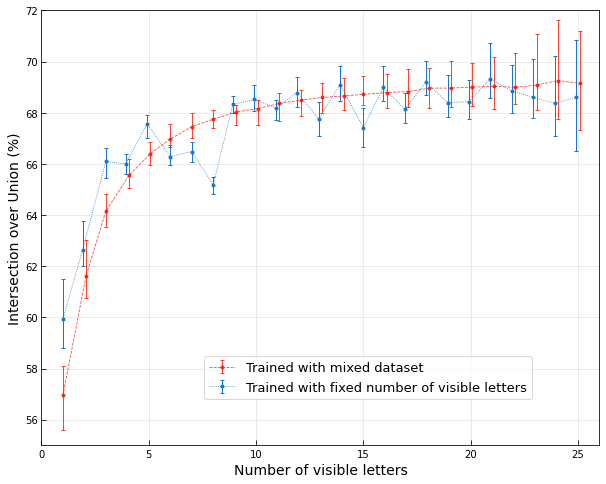

In [ ]:
plt.figure(0, (10, 8))
ax = plt.subplot(111)
# before it used , fmt='.k'


plt.errorbar(n_visible_letters_m, chkp_m['ious_median'], elinewidth=1, linewidth=0.8, yerr=error_bars_m, color='#ff1500',
             ls='--', fmt='.', ecolor='#ff1500', capsize=2, alpha=0.8, label='Trained with mixed dataset'); # red
plt.errorbar(n_visible_letters_f, chkp_f['ious_median'], elinewidth=1, linewidth=0.8, yerr=error_bars_f, color='#1776cf',
             ecolor='#1776cf', fmt='.', ls=':', capsize=2, alpha=1, label='Trained with fixed number of visible letters');  # blue
plt.xlabel('Number of visible letters', fontsize=14)
plt.ylabel('Intersection over Union (%)', fontsize=14)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.xlim([0, 26])
plt.ylim([55, 72])
plt.legend(fontsize=13, bbox_to_anchor=(0.28, 0.22), loc='upper left')
# plt.tick_params(which='both', top='off', left='off', right='off',  bottom='off') # turn off bottom ticks
# plt.set_major_locator(MultipleLocator(1))
plt.tick_params(direction='in', color='black', length=5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.savefig('final/baseline_iou.pdf', format='pdf', bbox_inches='tight')

# plt.tight_layout()


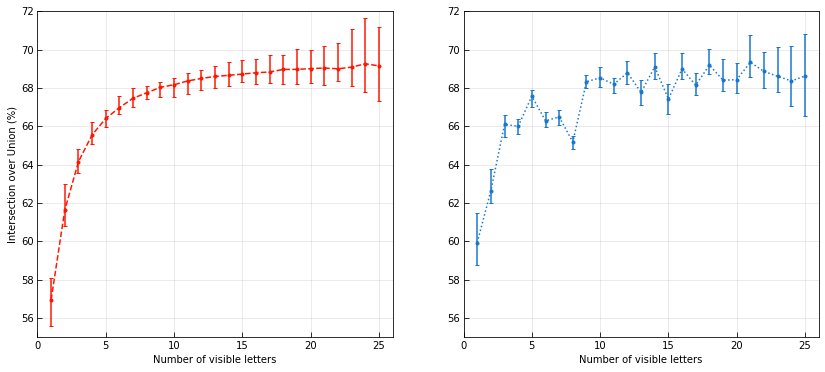

In [ ]:
plt.figure(0, (14, 6))
plt.subplot(121)
# before it used , fmt='.k'
plt.errorbar(n_visible_letters_, chkp_m['ious_median'], yerr=error_bars_m, color='#ff1500', ls='--', fmt='.', ecolor='#ff1500', capsize=2, alpha=1);
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')

plt.xlim([0, 26])
plt.ylim([55, 72])
plt.xlabel('Number of visible letters')
plt.ylabel('Intersection over Union (%)')
plt.tick_params(direction='in', color='black', length=5)

plt.subplot(122)
plt.errorbar(n_visible_letters_, chkp_f['ious_median'], yerr=error_bars_f, color='#1776cf', ecolor='#1776cf', fmt='.', ls=':', capsize=2, alpha=1);
plt.xlabel('Number of visible letters')
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.xlim([0, 26])
plt.ylim([55, 72])
plt.tick_params(direction='in', color='black', length=5)
# plt.tick_params(which='both', top='off', left='off', right='off',  bottom='off') # turn off bottom ticks
# plt.set_major_locator(MultipleLocator(1))
plt.tick_params(direction='in', color='black', length=5)
plt.savefig('final/baseline_iou_separate.pdf', format='pdf', bbox_inches='tight')

# plt.tight_layout()

# presumably the error bars in the extremities because in the training process he will have seen fewer examples with similar
# N_visible_letters than if we were in the middle. If we were interested in
# training a more "fair" letter generator we presumably could change the error bars by adding more examples in the extremities

In [ ]:
# pickle_dump(init_ious_appropriate, 'init_ious_dict_approppriate.dat')

# init_ious_dict = {p:iou for (p, iou) in zip(probs_choice, init_ious)}
# pickle_dump(init_ious_dict, 'init_ious_dict_directly_0.dat')

# pickle_dump(valid_metrics_init, BASE_DIR+'/pickle/valid_metrics_init.dat')

# valid_metrics_init = pickle_load('valid_metrics_init.dat')

## SPENs

### Unroll

In [ ]:
@dataclass
class UnrollConfigNew:
    '''To configure the unrolling algorithm set those parameters below.

    It's not exactly necessary, but is helpful to have the configuration
    as a dataclass (Google Colab still doesn't type check anything though.)
    '''

    n_iter_inference: int
    inner_lr: float
    init_mode: str
    to_squeeze: bool = False
    entropy_factor: float = 0.
    plot_y: bool = False
    plot_hist: bool = False
    to_print: bool = False

    def __post_init__(self):
        # With Google Colab we can't easily use type hints, so we add this
        # falta o logits_y_0
        self.inner_lr = torch.tensor(self.inner_lr, device=device)
        if not (isinstance(self.n_iter_inference, int) and isinstance(self.inner_lr, torch.Tensor) and 
            isinstance(self.init_mode, str) and isinstance(self.to_squeeze, bool) and
            isinstance(self.entropy_factor, float) and isinstance(self.plot_y, bool) 
            and isinstance(self.plot_hist, bool) and isinstance(self.to_print, bool)):
            raise TypeError('The parameters must be of the given types!')
        
        if not self.init_mode in ['random', 'zero', 'average', 'autoencoder']:
            raise Exception("init_mode must be 'random', 'zero', 'average', or'autoencoder'.")

    def __iter__(self):
        # Dataclass doesn't unpack by default
        return iter(astuple(self))
    
    def print_training_repr(self):
        print(f'Unroll Config: n_iter_inference: {self.n_iter_inference} • inner_lr: {self.inner_lr.item()} • '
              f'init_mode: {self.init_mode}')

In [ ]:
class UnrollEnergyNew(nn.Module):
    '''
    [...] This module is to be optimized in the space of parameters of the energy
    function and the space of hyper-parameters of the optimizer (...)
    '''
    def __init__(self, energy_net, loss_function, unroll_config):
        # If I pass energy_net here pytorch automatically assumes that I want
        # the parameters of energy_net to be parameters of the module
        # But i have extra (decoding parameters) that I don't want to include.
        # Is it even a problem?

        '''[...]'''
        super(UnrollEnergyNew, self).__init__()
        self.energy_net = energy_net
        self.loss_function = loss_function
        self.n_iter_inference, self.inner_lr, self.init_mode, self.to_squeeze, \
        self.entropy_factor, self.plot_y, self.plot_hist, self.to_print = unroll_config
        
    def forward(self, x, y, letter_masks, lr, create_graph=True, logits_y_0=None):
        # The ground truth y is here for the computation of the loss
        
        current_batch_size = x.shape[0] 
        shape_logits_0 = ((~letter_masks).sum().item(), *LETTER_SHAPE)
        
        if logits_y_0 is None:
            if self.init_mode == 'random':
                logits_y = torch.randn(shape_logits_0).to(device)
            elif self.init_mode == 'zero':
                logits_y = torch.zeros(shape_logits_0).to(device)
            elif self.init_mode == 'average':
                logits_y = average_of_letter_for_init[:current_batch_size][~letter_masks].to(device)
            elif self.init_mode == 'autoencoder':
                logits_y = autoencoder(x)[~letter_masks].to(device)

            if self.to_squeeze: # compress the logits with the custom squeeze function 
                logits_y = squeeze(logits_y)
        else:
            assert logits_y_0.shape == shape_logits_0
            logits_y = logits_y_0

        loss = torch.zeros(1, requires_grad=True, device=device)

        with torch.no_grad():
            y_ = torch.sigmoid(logits_y)
            y_pred_discrete = discretize(y_)

        if self.plot_hist:
            plt.hist(logits_y.detach().cpu().numpy().flatten(), 100); plt.show()
            # plt.hist(y_.detach().cpu().numpy().flatten(), 100); plt.show()

        if self.plot_y:
            plt.imshow(y_pred_discrete[0].cpu().detach().numpy()); plt.show()

        for n in range(self.n_iter_inference):
            
            logits_y = logits_y.clone().detach().requires_grad_()
            x[~letter_masks] = torch.sigmoid(logits_y)
            
            # Não devia ser negative entropy?
            if self.entropy_factor == 0.:
                energy = self.energy_net(x.clone(), mode='usual')
            else:
                energy = self.energy_net(x.clone(), mode='usual') + self.entropy_factor*entropy(logits_y)
            
            # Compute the gradient of the energy wrt y_.
            # This gradient grad_E_y is itself differentiable since create_graph=True
            grad_E_logits_y, = torch.autograd.grad(energy, inputs=logits_y,
                                        grad_outputs=torch.ones_like(energy),
                                        create_graph=create_graph)

            logits_y = logits_y - lr*grad_E_logits_y
            loss = loss + self.loss_function(logits_y, y)/(self.n_iter_inference - n)

            with torch.no_grad():
                y_ = torch.sigmoid(logits_y)
                y_pred_discrete = discretize(y_)



            if self.to_print:
                print('logits min max', logits_y.min().item(), logits_y.max().item())
                print('grad_E_logits_y min max', grad_E_logits_y.min().item(), grad_E_logits_y.max().item())

            if self.plot_y:
                plt.imshow(y_pred_discrete[0].cpu().detach().numpy()); plt.show()

            if self.plot_hist:
                plt.hist(logits_y.detach().cpu().numpy().flatten(), 100); plt.show()

        loss = loss/self.n_iter_inference
        return logits_y, loss

In [ ]:
@dataclass
class UnrollConfig:
    '''To configure the unrolling algorithm set those parameters below.

    It's not exactly necessary, but is helpful to have the configuration
    as a dataclass (Google Colab still doesn't type check anything though.)
    '''

    n_iter_inference: int
    inner_lr: float
    random_init: bool = False
    init_mode: str = 'pass'
    average_of_letter_init: bool = False
    entropy_factor: float = 0.
    plot_y: bool = False
    plot_hist: bool = False
    to_print: bool = False

    def __post_init__(self):
        # With Google Colab we can't easily use type hints, so we add this
        # falta o logits_y_0
        self.inner_lr = torch.tensor(self.inner_lr, device=device)
        if not (isinstance(self.n_iter_inference, int) and isinstance(self.inner_lr, torch.Tensor) and 
            isinstance(self.random_init, bool) and isinstance(self.init_mode, str) and isinstance(self.average_of_letter_init, bool) and
            isinstance(self.entropy_factor, float) and isinstance(self.plot_y, bool) 
            and isinstance(self.plot_hist, bool) and isinstance(self.to_print, bool)):
            raise TypeError('The parameters must be of the given types!')
        
        if not self.init_mode in ['pass', 'squeeze']:
            raise Exception("init_mode must be either 'pass' (do nothing) or 'squeeze'")

    def __iter__(self):
        # Dataclass doesn't unpack by default
        return iter(astuple(self))
    
    def print_training_repr(self):
        print(f'Unroll Config: n_iter_inference: {self.n_iter_inference} • inner_lr: {self.inner_lr.item()} • '
              f'random_init: {self.random_init} • entropy_factor: {self.entropy_factor}')

In [ ]:
I_FONT = 0 # apagar aqui e mais à frente

In [ ]:
class UnrollEnergy(nn.Module):
    '''
    [...] This module is to be optimized in the space of parameters of the energy
    function and the space of hyper-parameters of the optimizer (...)
    '''
    def __init__(self, energy_net, loss_function, unroll_config):
        # If I pass energy_net here pytorch automatically assumes that I want
        # the parameters of energy_net to be parameters of the module
        # But i have extra (decoding parameters) that I don't want to include.
        # Is it even a problem?

        '''[...]'''
        super(UnrollEnergy, self).__init__()
        self.energy_net = energy_net
        self.loss_function = loss_function
        self.n_iter_inference, self.inner_lr, self.random_init, self.init_mode, self.average_of_letter_init, \
        self.entropy_factor, self.plot_y, self.plot_hist, self.to_print = unroll_config
        
    def forward(self, x, y, letter_masks, lr, create_graph=True, logits_y_0=None):
        global I_FONT
        # The ground truth y is here for the computation of the loss
        
        current_batch_size = x.shape[0] 
        shape_logits_0 = ((~letter_masks).sum().item(), *LETTER_SHAPE)
        
        if logits_y_0 is None:
            if self.random_init:
                logits_y = torch.randn(shape_logits_0).to(device)
            elif self.average_of_letter_init:
                logits_y = average_of_letter_for_init[:current_batch_size][~letter_masks].to(device)
            else:
                logits_y = torch.zeros(shape_logits_0).to(device)

            if self.init_mode == 'pass': # usual mode without change of the logits
                pass
            elif self.init_mode == 'squeeze':  # compress the logits with the custom squeeze function
                logits_y = squeeze(logits_y)
        else:
            assert logits_y_0.shape == shape_logits_0
            logits_y = logits_y_0

        loss = torch.zeros(1, requires_grad=True, device=device)

        with torch.no_grad():
            y_ = torch.sigmoid(logits_y)
            y_pred_discrete = discretize(y_)

        if self.plot_hist:
            plt.hist(logits_y.detach().cpu().numpy().flatten(), 100); plt.show()
            # plt.hist(y_.detach().cpu().numpy().flatten(), 100); plt.show()

        if self.plot_y:
            plt.imshow(y_pred_discrete[0].cpu().detach().numpy()); plt.show()

        for n in range(self.n_iter_inference):
            
            logits_y = logits_y.clone().detach().requires_grad_()
            x[~letter_masks] = torch.sigmoid(logits_y)

            for i in range(current_batch_size):
                plot_font(x[i].cpu().detach().numpy(), mode='2_rows', \
                                to_show=False, to_save=True, save_dir='images_for_plots/spens/inference/', \
                                filename=f'{I_FONT+i} - step: {n}')

            # Não devia ser negative entropy?
            if self.entropy_factor == 0.:
                energy = self.energy_net(x.clone(), mode='usual')
            else:
                energy = self.energy_net(x.clone(), mode='usual') + self.entropy_factor*entropy(logits_y)
            
            # Compute the gradient of the energy wrt y_.
            # This gradient grad_E_y is itself differentiable since create_graph=True
            grad_E_logits_y, = torch.autograd.grad(energy, inputs=logits_y,
                                        grad_outputs=torch.ones_like(energy),
                                        create_graph=create_graph)

            logits_y = logits_y - lr*grad_E_logits_y
            loss = loss + self.loss_function(logits_y, y)/(self.n_iter_inference - n)

            with torch.no_grad():
                y_ = torch.sigmoid(logits_y)
                y_pred_discrete = discretize(y_)

            if self.to_print:
                print('logits min max', logits_y.min().item(), logits_y.max().item())
                print('grad_E_logits_y min max', grad_E_logits_y.min().item(), grad_E_logits_y.max().item())

            if self.plot_y:
                plt.imshow(y_pred_discrete[0].cpu().detach().numpy()); plt.show()

            if self.plot_hist:
                plt.hist(logits_y.detach().cpu().numpy().flatten(), 100); plt.show()
        
        x[~letter_masks] = torch.sigmoid(logits_y)

        for i in range(current_batch_size):
            plot_font(x[i].cpu().detach().numpy(), mode='1_row', \
                            to_show=False, to_save=True, save_dir='images_for_plots/spens/inference/', \
                            filename=f'{I_FONT+i} - step: {n+1}')

        I_FONT += current_batch_size
        loss = loss/self.n_iter_inference
        return logits_y, loss

### TRAINING

#### Train routine

In [ ]:
# create entire config from 3 ou 4 different configs.
# Is it hashable to use as key for the dictionary saving the results?

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    '''To configure the training routine set those parameters below.

    It's not exactly necessary, but is helpful to have the configuration
    as a dataclass (Google Colab still doesn't type check anything though.)
    '''

    outer_lr: float
    n_epochs: int
    k_patience: int
    inner_lr_is_parameter: bool = False
    use_new_unroll_config: bool = True
    saved_checkpoint: Union[dict, None] = None
    metrics_names: Tuple = ('bce', 'custom_bce', 'iou')
    force_init_zero_validation: bool = True
    verbose: bool = False

    def __post_init__(self):
        # With Google Colab we can't easily use type hints, so we add this
        if not (isinstance(self.outer_lr, float) and isinstance(self.n_epochs, int) and 
            isinstance(self.k_patience, int) and isinstance(self.metrics_names, tuple) and 
            isinstance(self.force_init_zero_validation, bool) and isinstance(self.verbose, bool)):
            raise TypeError('The parameters must be of the given types!')

    def __iter__(self):
        # Dataclass doesn't unpack by default
        return iter(astuple(self))
    
    def print_training_repr(self):
        print(f'Train Config: outer_lr: {self.outer_lr}')

In [ ]:
# class TrainEnergyNet:

# make sure the seeding is done each time the function runs!

def train_unrolled(dataset_config, energy_net_config, unroll_config, training_config):

    def make_checkpoint_dict():
        scores = {'train_iou': train_iou[:epoch], 'valid_iou': valid_iou[:epoch],
                  'train_bce': train_bce[:epoch], 'valid_bce': valid_bce[:epoch]}
        checkpoint = {'file_name': beginning_time_repr + '.dat',
                      'save_dir': 'run_logs/',
                      'duration': current_time() - beginning_time,
                      'model': unrolled,
                      'best_optimizer_state': best_optimizer_state,
                      'last_optimizer_state': last_optimizer_state,
                      'continuation': continuation,
                      'best_states': unrolled_best_states,
                      'last_states': unrolled_last_states,
                      'inner_lr': inner_lr_,
                      'best_rngs_states': best_rngs_states, 
                      'last_rngs_states': last_rngs_states,
                      'k_valid': k_valid,
                      'k_train': k_train,
                      'scores': scores,
                      'max_valid_iou': max_valid_iou,
                      'max_train_iou': max_train_iou,
                      'min_valid_bce_loss': min_valid_bce_loss,
                      'epoch': epoch,
                      'epoch_max_valid_iou': epoch_max_valid_iou,
                      'epoch_max_train_iou': epoch_max_train_iou,
                      'dataset_config': dataset_config,
                      'energy_net_config': energy_net_config,
                      'unroll_config': unroll_config,
                      'training_config': training_config}
        return checkpoint

    try:
        # Initialize dataset. Using the seed, we make sure that ... (complete)
        train_dataset = FontsDataset(train_data, dataset_config)
        valid_dataset = FontsDataset(valid_data, dataset_config)

        batch_size = dataset_config.batch_size
        train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True,
                                      num_workers=0, pin_memory=True)
        valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False,
                                      num_workers=0, pin_memory=True)

        inner_lr = unroll_config.inner_lr

        outer_lr, n_epochs, k_patience, inner_lr_is_parameter, use_new_unroll_config, saved_checkpoint, metrics_names, \
                            force_init_zero_validation, verbose = training_config
                
        criterion = nn.BCEWithLogitsLoss().to(device)
        
        energy_net = EnergyNet(energy_net_config).to(device)
        
        if inner_lr_is_parameter:
            log_inner_lr = torch.nn.Parameter(inner_lr.log()).to(device)
            inner_lr_ = log_inner_lr.exp()
            parameters_to_optimize = list(energy_net.parameters()) + [log_inner_lr]
            
        else:
            inner_lr_ = inner_lr.to(device)
            parameters_to_optimize = list(energy_net.parameters())

        if unroll_config.init_mode == 'autoencoder':
            parameters_to_optimize = parameters_to_optimize + list(autoencoder.parameters())

        optimizer = optim.AdamW(parameters_to_optimize, lr=outer_lr, weight_decay=0.1)
        
        if use_new_unroll_config:
            unrolled = UnrollEnergyNew(energy_net, criterion, unroll_config).to(device)
            if unroll_config.init_mode == 'random' and force_init_zero_validation:
                unroll_config_valid = replace(unroll_config, init_mode='zero')
            else:
                unroll_config_valid = unroll_config
            unrolled_valid = UnrollEnergyNew(energy_net, criterion, unroll_config_valid).to(device)
        else:
            unrolled = UnrollEnergy(energy_net, criterion, unroll_config).to(device)
            if unroll_config.random_init and force_init_zero_validation:
                unroll_config_valid = replace(unroll_config, random_init=False)
            else:
                unroll_config_valid = unroll_config
            unrolled_valid = UnrollEnergy(energy_net, criterion, unroll_config_valid).to(device)

        # Print configurations and header for the scores information
        dataset_config.print_training_repr()
        energy_net_config.print_training_repr()
        unroll_config.print_training_repr()
        training_config.print_training_repr()
        print_header_scores()

        beginning_time = current_time()
        beginning_time_repr = current_time_repr()

        # Save last 3 best models, and 1 model every 100 iterations for the maximum of 3 of them
        unrolled_best_states = deque(maxlen=3)
        unrolled_last_states = deque(maxlen=3)

        # 
        train_iou = np.zeros(n_epochs)
        valid_iou = np.zeros(n_epochs)
        train_bce = np.zeros(n_epochs)
        valid_bce = np.zeros(n_epochs)

        if saved_checkpoint is None:
            continuation = True
            # Set seed to assure reproducibility of the order of the presented fonts:
            torch.manual_seed(dataset_config.initial_seed)
            min_valid_bce_loss = np.inf
            max_valid_iou = 0.
            max_train_iou = 0.
            k_valid = 0
            k_train = 0
        else:
            continuation = False
            if saved_checkpoint['epoch_max_valid_iou'] == saved_checkpoint['epoch']:
                unrolled.load_state_dict(saved_checkpoint['best_states'][-1])
                optimizer.load_state_dict(saved_checkpoint['best_optimizer_state'])
                rng_state, np_rng_state, torch_rng_state = saved_checkpoint['best_rngs_states']
            else:
                unrolled.load_state_dict(saved_checkpoint['last_states'][-1])
                optimizer.load_state_dict(saved_checkpoint['last_optimizer_state'])
                rng_state, np_rng_state, torch_rng_state = saved_checkpoint['last_rngs_states']
        
            torch.set_rng_state(torch_rng_state)
            train_dataset.set_rngs_states((rng_state, np_rng_state))

            min_valid_bce_loss = saved_checkpoint['min_valid_bce_loss']
            max_valid_iou = saved_checkpoint['max_valid_iou']
            max_train_iou = saved_checkpoint['max_train_iou']
            k_valid = saved_checkpoint['k_valid']
            k_train = saved_checkpoint['k_train']
        epoch = 1
        epoch_max_valid_iou = 1
        epoch_max_train_iou = 1
        best_optimizer_state = None
        last_optimizer_state = None
        best_rngs_states = None
        last_rngs_states = None

        while k_valid != k_patience and epoch <= n_epochs:

            if verbose:
                print(f'----- Epoch: {epoch} -----')
            # print(f'inner lr: {inner_lr_.item():.3f}')

            # Mudar o que se segue se o modo não for "prob"!

            train_dataset.build_masked_input(dataset_config)

            # if inner_lr_is_parameter:
            #     print('ho')
            #     unroll_config = replace(unroll_config, inner_lr=inner_lr_)
            #     unroll_config_valid = replace(unroll_config_valid, inner_lr=inner_lr_)
            #     unrolled = UnrollEnergy(energy_net, criterion, unroll_config).to(device)
            #     unrolled_valid = UnrollEnergy(energy_net, criterion, unroll_config_valid).to(device)

            ### TRAINING
            if verbose:
                print('--- Train ---')

            energy_net.train()

            running_metrics = init_running_metrics(metrics_names)
            total_n_missing_letters = 0
         
            for i, (x, y, letter_masks) in enumerate(train_dataloader):
                if verbose:
                    print(f'minibatch: {i}')

                # if i == 0:
                #     for j in range(3):
                #         plot_font(x[j].cpu())

                x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
                energy_net.zero_grad()
               
                # É preciso fazer clone().detach() aqui?
                logits_y, custom_bce_loss = unrolled(x.clone().detach(), y[~letter_masks],
                                                     letter_masks, inner_lr_)
                
                custom_bce_loss.backward()
                assert None not in get_usual_energy_net_params(energy_net) # preciso?
                optimizer.step()

                if inner_lr_is_parameter:
                    inner_lr_ = log_inner_lr.exp()

                with torch.no_grad():
                    y_ = torch.sigmoid(logits_y)
                    y_pred_discrete = discretize(y_)
                    
                running_metrics, total_n_missing_letters = update_running_metrics(running_metrics, logits_y, 
                                                                        y[~letter_masks], letter_masks, 
                                                                        total_n_missing_letters,
                                                                        custom_loss=custom_bce_loss,
                                                                        criterion=criterion)
                
            train_metrics = compute_final_metrics(running_metrics,
                                                len(train_dataloader.dataset),
                                                total_n_missing_letters)


            ### VALIDATION - Notice that Autograd is turned on here!
            if verbose:
                print('--- Valid ---')

            energy_net.eval()

            running_metrics = init_running_metrics(metrics_names)
            total_n_missing_letters = 0
            
            # tenho que passar parametro para create_graph para minimizar tempo de inferencia
            
            for i, (x, y, letter_masks) in enumerate(valid_dataloader):

                if verbose:
                    print(f'minibatch: {i}')

                x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
                energy_net.zero_grad()

                logits_y, custom_bce_loss = unrolled_valid(x, y[~letter_masks], letter_masks,
                                                           inner_lr_, create_graph=False)

                with torch.no_grad():
                    y_ = torch.sigmoid(logits_y)
                    y_pred_discrete = discretize(y_)

                running_metrics, total_n_missing_letters = update_running_metrics(running_metrics, logits_y, 
                                                                        y[~letter_masks], letter_masks, 
                                                                        total_n_missing_letters,
                                                                        custom_loss=custom_bce_loss, 
                                                                        criterion=criterion)

            valid_metrics = compute_final_metrics(running_metrics,
                                                len(valid_dataloader.dataset),
                                                total_n_missing_letters)
            
            train_iou[epoch-1] = train_metrics['iou']
            valid_iou[epoch-1] = valid_metrics['iou']
            train_bce[epoch-1] = train_metrics['bce']
            valid_bce[epoch-1] = valid_metrics['bce']


            ### CHECKPOINTS:
            if valid_metrics['iou'] > max_valid_iou:
                max_valid_iou = valid_metrics['iou']
                epoch_max_valid_iou = epoch
                unrolled_best_states.append(copy.deepcopy(unrolled.state_dict()))
                best_optimizer_state = copy.deepcopy(optimizer.state_dict())
                best_rngs_states = copy.deepcopy((*train_dataset.get_rngs_states(), \
                                                             torch.get_rng_state()))
                checkpoint = make_checkpoint_dict()
                save_checkpoint(**checkpoint)
                k_valid = 0
            else:
                k_valid += 1
            
            if train_metrics['iou'] > max_train_iou:
                max_train_iou = train_metrics['iou']
                epoch_max_train_iou = epoch
                k_train = 0
            else:
                k_train += 1
            
            if epoch % 100 == 0:
                unrolled_last_states.append(copy.deepcopy(unrolled.state_dict()))
                last_optimizer_state = copy.deepcopy(optimizer.state_dict())
                last_rngs_states = copy.deepcopy((*train_dataset.get_rngs_states(), \
                                                             torch.get_rng_state()))
                checkpoint = make_checkpoint_dict()
                save_checkpoint(**checkpoint)

            # This next one is computed only for curiosity
            if valid_metrics['bce'] < min_valid_bce_loss:
                min_valid_bce_loss = valid_metrics['bce']

            print_scores(epoch, train_metrics, valid_metrics, k_valid, k_train, max_valid_iou, max_train_iou)

            epoch += 1

    except KeyboardInterrupt:
        print('\nDone! (Interrupted)\n')
        
    except:
        print(f"\nUnexpected error: {sys.exc_info()[0]}\n")
        raise

    else:        
        print('\nDone! (End of patience or maximum number of epochs exceeded!)\n')

    return unrolled_best_states, unrolled_last_states, checkpoint

#### Train multiple

In [ ]:
class Config(DatasetConfig, EnergyNetConfig, UnrollConfig, TrainingConfig):
    def __init__(self, dataset_config, energy_net_config, unroll_config, training_config):
        DatasetConfig.__init__(self, **asdict(dataset_config))
        EnergyNetConfig.__init__(self, **asdict(energy_net_config))
        UnrollConfig.__init__(self, **asdict(unroll_config))
        TrainingConfig.__init__(self, **asdict(training_config))
    def __repr__(self):
        ds = DatasetConfig.__repr__(self)
        e = EnergyNetConfig.__repr__(self)
        u = UnrollConfig.__repr__(self)
        t = TrainingConfig.__repr__(self)
        return ds + e + u + t

In [ ]:
def train_unrolled_multiple_values(dataset_config, energy_net_config, unroll_config, training_config, **values_params):

    types_of_configs = [dataset_config, energy_net_config, unroll_config, training_config]  # criar classe com todos os atributos?
    # check iterable

    best_results = {}
    last_results = {}
    for param, values in values_params.items():
        best_results[param] = {}
        last_results[param] = {}
        for i, type_of_config in enumerate(types_of_configs):
            for attribute in get_created_class_attributes(type_of_config):
                if param == attribute:
                    saved_type_of_config = copy.deepcopy(type_of_config)
                    for value in values:
                        name_param_value = {param: value}
                        type_of_config_ = replace(type_of_config, **name_param_value)
                        types_of_configs[i] = type_of_config_
                        unrolled_best_states, unrolled_last_states = train_unrolled(*types_of_configs)
                        best_results[param][value] = unrolled_best_states
                        last_results[param][value] = unrolled_last_states

                        time.sleep(0.3)  # preciso?
                        print('\n')

    return best_results, last_results

In [ ]:
def train_unrolled_multiple_visible_letters(dataset_config, energy_net_config, unroll_config, training_config, possible_visible_letters):

    best_results = {}
    last_results = {}
    for n_visible_letters in n_visible_letters_iter:
        dataset_config
        unrolled_best_states, unrolled_last_states = train_unrolled(replace(dataset_config,
                        n_visible_letters=n_visible_letters), energy_net_config, unroll_config, training_config)
        best_results[n_visible_letters] = unrolled_best_states
        last_results[n_visible_letters] = unrolled_last_states
        
        time.sleep(0.3)  # preciso?
        print('\n')

    return best_results, last_results

In [ ]:
# training_config_A = replace(training_config_A, saved_unrolled_parameters=unrolled.state_dict())

In [ ]:
# Iter = 1

dataset_config = DatasetConfig(batch_size=180, dataset_mode='fixed', n_visible_letters=21)

# n_channels_conv = (120, 140, 180, 220) -> 72,  (80, 100, 130, 160) -> 73,3    (50, 70, 100, 130 + (100, 50)) -> 73 
# n_linear_features = (200, 80)
 # (32, 64, 128, 256) + (150, 60)

energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220), 
                          n_layers_per_conv_block = (2, 2, 3, 3),
                          kernel_sizes = (5, 5, 3, 3),
                          n_linear_features = (200, 80),  
                          dropout_probs = (0.3, 0.5))

unroll_config_A = UnrollConfig(n_iter_inference=1, inner_lr=6.E-03)  # antes estava em 6.e-3

training_config_A = TrainingConfig(outer_lr=0.5E-2, n_epochs=5000, k_patience=1500)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

unrolled_best_states, unrolled_last_states, best_checkpoint, last_checkpoint = \
                    train_unrolled(dataset_config, energy_net_config_A, unroll_config_A, training_config_A)

In [ ]:
dataset_config = DatasetConfig(batch_size=180, dataset_mode='fixed', n_visible_letters=21)

# n_channels_conv = (120, 140, 180, 220) -> 72,  (80, 100, 130, 160) -> 73,3    (50, 70, 100, 130 + (100, 50)) -> 73 
# n_linear_features = (200, 80)
 # (32, 64, 128, 256) + (150, 60)
 
energy_net_config_A = EnergyNetConfig(n_channels_conv = (80, 100, 130, 160), 
                          n_layers_per_conv_block = (2, 2, 3, 3),
                          kernel_sizes = (5, 5, 3, 3),
                          n_linear_features = (150, 60),  
                          dropout_probs = (0.3, 0.5))

unroll_config_A = UnrollConfig(n_iter_inference=1, inner_lr=0.3E2, plot_hist=False, to_print=False)  # antes estava em 6.e-3

training_config_A = TrainingConfig(outer_lr=2.E-3, n_epochs=10000, k_patience=1500)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

# outer 2e-3 e inner 1.e2 funcionou bem -> 74 para n_iter = 1

unrolled_best_states, unrolled_last_states = train_unrolled(dataset_config, energy_net_config_A,
                                                            unroll_config_A, training_config_A)


best_results, last_results = train_unrolled_multiple_visible_letters(dataset_config,
        energy_net_config_A, unroll_config_A, training_config_A, n_visible_letters_iter=[1, 2, 4, 7, 10, 13, 17, 21, 25])

In [ ]:
# ORIGINAL

dataset_config = DatasetConfig(batch_size=180, dataset_mode='prob', prob_choice=0.8)

# n_channels_conv = (120, 140, 180, 220) -> 72,  (80, 100, 130, 160) -> 73,3    (50, 70, 100, 130 + (100, 50)) -> 73 
# n_linear_features = (200, 80)
 # (32, 64, 128, 256) + (150, 60)

energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220), 
                          n_layers_per_conv_block = (2, 2, 3, 3),
                          kernel_sizes = (5, 5, 3, 3),
                          n_linear_features = (200, 80),  
                          dropout_probs = (0.3, 0.5))

unroll_config_A = UnrollConfig(n_iter_inference=5, inner_lr=6.E-03)  # antes estava em 6.e-3

training_config_A = TrainingConfig(outer_lr=0.5E-2, n_epochs=5000, k_patience=1500)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

unrolled_best_states, unrolled_last_states, best_checkpoint, last_checkpoint = \
                    train_unrolled(dataset_config, energy_net_config_A, unroll_config_A, training_config_A)

In [ ]:
# pickle_dump(unrolled_best_states, 'unrolled_best_states_80.pt')
unrolled_best_states = pickle_load('unrolled_best_states_80.pt')

In [ ]:
print(energy_net_config_A)

EnergyNetConfig(n_channels_conv=(120, 140, 180, 220), n_layers_per_conv_block=(2, 2, 3, 3), kernel_sizes=(5, 5, 3, 3), n_linear_features=(200, 80), dropout_probs=(0.0, 0.0), use_batchnorm=False, beta=1.0, last_softplus=False, use_softplus=True)


#### Experiments

In [ ]:
dataset_config = DatasetConfig(batch_size=180, dataset_mode='fixed', n_visible_letters=1)

energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220), 
                          n_layers_per_conv_block = (2, 2, 3, 3),
                          kernel_sizes = (5, 5, 3, 3),
                          n_linear_features = (200, 80),  
                          dropout_probs = (0.3, 0.5))

In [ ]:
# bons resultados: inner_lr estava em 50, outer_lr 1.e-3; inner_lr em 30 ainda melhor, ainda melhor em 10

# outer 2e-3 e inner 1.e2 funcionou bem -> 74 para n_iter = 1

In [ ]:
set_trace()

In [ ]:
print(type(torch.tensor([1.])))

<class 'torch.Tensor'>


In [ ]:
autoencoder = copy.deepcopy(baseline)

# baseline = copy.deepcopy(autoencoder)

In [ ]:
inner_lr=30.
outer_lr = 3.E-4

dataset_config = DatasetConfig(batch_size=48, dataset_mode='fixed', n_visible_letters=13)

unroll_config_A = UnrollConfig(n_iter_inference=3, inner_lr=inner_lr, plot_hist=False, to_print=False) #inner_lr estava em 50

energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220), 
                          n_layers_per_conv_block = (2, 2, 3, 3),
                          kernel_sizes = (5, 5, 3, 3),
                          n_linear_features = (200, 80),  
                          dropout_probs = (0.3, 0.5), beta=1.)

training_config_A = TrainingConfig(outer_lr=outer_lr, inner_lr_is_parameter=False, n_epochs=500000, k_patience=50000, use_new_unroll_config=False)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

unrolled_best_states, unrolled_last_states, checkpoint = \
                    train_unrolled(dataset_config, energy_net_config_A, unroll_config_A, training_config_A)

Dataset Config: batch_size: 48 • mode: fixed • n_visible_letters: 13
EnergyNet Config: n_channels_conv: (120, 140, 180, 220) • n_layers_per_conv_block: (2, 2, 3, 3) • kernel_sizes: (5, 5, 3, 3)
                  n_linear_features: (200, 80) • dropout_probs: (0.3, 0.5) • beta: 1.0
Unroll Config: n_iter_inference: 3 • inner_lr: 30.0 • random_init: False • entropy_factor: 0.0
Train Config: outer_lr: 0.0003

Epoch  |  Custom BCE   BCE (train)   BCE (valid)   IOU (train)   IOU (valid)  |  k_valid     k_train    Max valid IoU   Max train IoU
1      |  0.424        0.693         0.693         15.36         16.00        |  0           0          16.00           15.36
2      |  0.424        0.693         0.693         15.33         16.00        |  1           1          16.00           15.36
3      |  0.424        0.693         0.693         15.36         16.00        |  2           0          16.00           15.36
4      |  0.424        0.693         0.693         15.36         16.00        | 

In [ ]:
inner_lr=20.
outer_lr = 2.E-4

dataset_config = DatasetConfig(batch_size=48, dataset_mode='fixed', n_visible_letters=21)

unroll_config_A = UnrollConfigNew(n_iter_inference=2, init_mode='autoencoder', to_squeeze=True, inner_lr=inner_lr, plot_hist=False, to_print=False) #inner_lr estava em 50

energy_net_config_A = EnergyNetConfig(n_channels_conv = (120, 140, 180, 220), 
                          n_layers_per_conv_block = (2, 2, 3, 3),
                          kernel_sizes = (5, 5, 3, 3),
                          n_linear_features = (200, 80),  
                          dropout_probs = (0.3, 0.5), beta=1.)

training_config_A = TrainingConfig(outer_lr=outer_lr, inner_lr_is_parameter=False, n_epochs=500000, k_patience=50000, use_new_unroll_config=True)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

unrolled_best_states, unrolled_last_states, checkpoint = \
                    train_unrolled(dataset_config, energy_net_config_A, unroll_config_A, training_config_A)

Streaming output truncated to the last 5000 lines.
454    |  0.068        0.090         0.097         77.56         76.39        |  5           3          77.21           77.57
455    |  0.068        0.091         0.096         76.97         76.68        |  6           4          77.21           77.57
456    |  0.068        0.091         0.097         77.43         76.81        |  7           5          77.21           77.57
457    |  0.070        0.093         0.097         77.18         76.09        |  8           6          77.21           77.57
458    |  0.069        0.092         0.097         76.92         76.20        |  9           7          77.21           77.57
459    |  0.067        0.090         0.096         77.68         77.06        |  10          0          77.21           77.68
460    |  0.069        0.091         0.098         77.37         76.93        |  11          1          77.21           77.68
461    |  0.068        0.090         0.097         77.54         76

In [ ]:
    inner_lr=30.
outer_lr = 1.E-3

unroll_config_A = UnrollConfig(n_iter_inference=1, inner_lr=inner_lr)

training_config_A = TrainingConfig(outer_lr=outer_lr, n_epochs=20000, k_patience=5000)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

# outer 2e-3 e inner 1.e2 funcionou bem -> 74 para n_iter = 1

unrolled_best_states, unrolled_last_states, checkpoint = \
                    train_unrolled(dataset_config, energy_net_config_A, unroll_config_A, training_config_A)

In [ ]:
inner_lr = 10.
outer_lr = 1.E-3

unroll_config_A = UnrollConfig(n_iter_inference=1, inner_lr=inner_lr, plot_hist=False, to_print=False) #inner_lr estava em 50

training_config_A = TrainingConfig(outer_lr=outer_lr, saved_model_parameters=best_checkpoint_partial['best_states'][-1],
                                    saved_optimizer=None,
                                   n_epochs=20000, k_patience=4000)  # antes outer-lr estava em 0.6e-2, cheguei a por em 0.3e-2

unrolled_best_states, unrolled_last_states, checkpoint = \
                    train_unrolled(dataset_config, energy_net_config_A, unroll_config_A, training_config_A)

Streaming output truncated to the last 5000 lines.
3981      0.142        0.142         0.158         63.36         61.92         5
3982      0.142        0.142         0.157         63.44         62.57         6
3983      0.140        0.140         0.158         63.94         61.21         7
3984      0.140        0.140         0.157         63.72         61.78         8
3985      0.144        0.144         0.158         63.22         61.53         9
3986      0.141        0.141         0.156         63.30         62.19         10
3987      0.141        0.141         0.158         63.86         62.14         11
3988      0.143        0.143         0.158         62.83         62.15         12
3989      0.143        0.143         0.158         63.11         61.72         13
3990      0.141        0.141         0.158         63.71         62.29         14
3991      0.144        0.144         0.159         63.24         61.41         15
3992      0.142        0.142         0.159         6

In [ ]:
with open('/content/drive/My Drive/thesis1/pickle/1.1/unrolled_parameters_so_zero.dat', 'rb') as f:
    unrolled_parameters = pickle.load(f)

with open('/content/drive/My Drive/thesis1/pickle/1.1/unrolled_parameters_0.05_0.1.dat', 'rb') as f:
    unrolled_parameters_1 = pickle.load(f)

with open('/content/drive/My Drive/thesis1/pickle/1.1/unrolled_parameters_0.2_0.4_0.6_0.9.dat', 'rb') as f:
    unrolled_parameters_2 = pickle.load(f)

unrolled_parameters.update(unrolled_parameters_1)
unrolled_parameters.update(unrolled_parameters_2)



dict_keys([0.0, 0.05, 0.1, 0.2, 0.4, 0.6, 0.9])


In [ ]:
pickle_dump(unrolled_best_states, '/1.1/unrolled_parameters_0.2_0.4_0.6_0.9.dat')

### TESTING

In [ ]:
pickle_dump(unrolled_best_state, 'unrolled_best_state_20_40_60_80_ini_0.dat')

# unrolled_best_state = pickle_load(BASE_DIR+'/pickle/unrolled_best_state.dat')

In [ ]:
pickle_dump(unrolled_best_state_for_setting, 'best_unrolled_big_net_parameters.dat')

In [ ]:
outer_lr = 1.E-2   #máximo 1.E-2 parece ser melhor, talve menos
inner_lr = 0.6E-02
init_mode = 0
plot_hist = False

#### Test routine

In [ ]:
print(checkpoint.keys())

dict_keys(['file_name', 'save_dir', 'duration', 'model', 'best_optimizer_state', 'last_optimizer_state', 'continuation', 'best_states', 'last_states', 'inner_lr_learned', 'best_rngs_states', 'last_rngs_states', 'k_valid', 'k_train', 'scores', 'max_valid_iou', 'max_train_iou', 'min_valid_bce_loss', 'epoch', 'epoch_max_valid_iou', 'epoch_max_train_iou', 'dataset_config', 'energy_net_config', 'unroll_config', 'training_config'])


In [ ]:
@dataclass(frozen=True)
class TestingConfig:
    '''To configure the testing routine set those parameters below.

    It's not exactly necessary, but is helpful to have the configuration
    as a dataclass (Google Colab still doesn't type check anything though.)
    '''

    saved_model_parameters: Union[OrderedDict, None] = None
    saved_model: Union[nn.Module, None] = None
    n_trials: int = 100
    set_eval: bool = True
    metrics_names: Tuple = ('bce', 'custom_bce', 'iou')
    force_init_zero_testing: bool = True
    print_testing_repr: bool = False
    print_results: bool = True
    plot_fonts: bool = False
    plot_whole_font: bool = True
    plot_grid_missing_letters: bool = False

    def __post_init__(self):

        if not (self.saved_model_parameters is None) ^ (self.saved_model is None):
            raise ValueError('Either saved_model_parameters or saved_model must be chosen!')
        # With Google Colab we can't easily use type hints, so we add this
        if not (isinstance(self.n_trials, int) and isinstance(self.set_eval, bool) and 
            isinstance(self.metrics_names, tuple) and isinstance(self.print_testing_repr, bool) and 
            isinstance(self.print_results, bool) and isinstance(self.plot_fonts, bool) and
            isinstance(self.plot_whole_font, bool) and isinstance(self.plot_grid_missing_letters, bool)):
            raise TypeError('The parameters must be of the given types!')

    def __iter__(self):
        # Dataclass doesn't unpack by default
        return iter(astuple(self))
    
    def print_training_repr(self):
        print(f'Train Config: outer_lr: {self.outer_lr}')

In [ ]:
def test_unrolled(testing_config, checkpoint=None, dataset_config=None, energy_net_config=None, unroll_config=None, dataset_to_test='test'):

    all_configs_except_testing = (dataset_config, energy_net_config, unroll_config)
    all_configs_except_testing_are_none = all(cfg is None for cfg in all_configs_except_testing)

    if not (checkpoint is None) ^ all_configs_except_testing_are_none:
        raise Exception('Either a checkpoint must be given, or all configurations '
                        '(dataset_config, energy_net_config, and unroll_config) must be given.')
    
    if checkpoint is not None:
        dataset_config = checkpoint['dataset_config']
        energy_net_config = checkpoint['energy_net_config']
        unroll_config = checkpoint['unroll_config']
        if 'inner_lr_learned' in checkpoint:
            inner_lr = checkpoint['inner_lr_learned']
        else:
            inner_lr = unroll_config.inner_lr
    
    assert dataset_to_test in ['test', 'valid', 'train']
    
    if dataset_to_test == 'test':
        dataset = FontsDataset(test_data, dataset_config)
    elif dataset_to_test == 'valid':
        dataset = FontsDataset(valid_data, dataset_config)
    elif dataset_to_test == 'train':
        dataset = FontsDataset(train_data, dataset_config)

    # Set seed to assure reproducibility of the order of the presented fonts:
    torch.manual_seed(dataset_config.initial_seed)

    batch_size = dataset_config.batch_size
    test_dataloader = DataLoader(dataset, batch_size, shuffle=False,
                                    num_workers=0, pin_memory=True)
    
    saved_model_parameters, saved_model, n_trials, set_to_eval, metrics_names, force_init_zero_testing, \
    print_testing_repr, print_results, plot_fonts, plot_whole_font, plot_grid_missing_letters = testing_config

    criterion = nn.BCEWithLogitsLoss().to(device)

    assert (saved_model_parameters is None) ^ (saved_model is None)

    if saved_model_parameters is not None:
        if unroll_config.random_init and force_init_zero_testing:
            unroll_config_test = replace(unroll_config, random_init=False)
        else:
            unroll_config_test = unroll_config

        energy_net = EnergyNet(energy_net_config).to(device)
        unrolled_test = UnrollEnergy(energy_net, criterion, unroll_config_test).to(device)
        unrolled_test.load_state_dict(saved_model_parameters)
    elif saved_model is not None:
        assert not unroll_config.random_init and not force_init_zero_testing, 'Not coded the possibility of having a saved model and forcing the init to be zero'
        unrolled_test = saved_model.to(device)
        energy_net = unrolled_test.energy_net
    
    if set_to_eval:
        energy_net.eval()
    else:
        energy_net.train()

    # Print configurations
    if print_testing_repr:
        dataset_config.print_training_repr()
        energy_net_config.print_training_repr()
        unroll_config.print_training_repr()
        testing_config.print_training_repr()
    
    ious = np.zeros(n_trials)

    for trial in range(n_trials):

        running_metrics = init_running_metrics(metrics_names)
        total_n_missing_letters = 0

        for j, (x, y, letter_masks) in enumerate(test_dataloader):
            batch_size_ = x.shape[0]
            x, y, letter_masks = x.to(device), y.to(device), letter_masks.to(device)
            energy_net.zero_grad()

            logits_y, custom_bce_loss = unrolled_test(x, y[~letter_masks], letter_masks,
                                                    inner_lr, create_graph=False)
            loss_usual = criterion(logits_y, y[~letter_masks])

            with torch.no_grad():
                y_ = torch.sigmoid(logits_y).cpu().detach().numpy()
                y_pred_discrete = discretize(y_)

            running_metrics, total_n_missing_letters = update_running_metrics(running_metrics, logits_y, 
                                                                    y[~letter_masks], letter_masks, 
                                                                    total_n_missing_letters,
                                                                    custom_loss=custom_bce_loss,
                                                                    criterion=criterion)

            if plot_fonts:
                # retirar a parte de gravar em disco!
                for i in range(batch_size_):
                    x_ = copy.deepcopy(x.detach())
                    x_[~letter_masks] = torch.tensor(y_pred_discrete, dtype=torch.float32).to(device)   # por mais simples
                    plot_font(x_[i].cpu().detach().numpy(), letter_masks[i].cpu().detach().numpy(), mode='2_rows', \
                              to_show=False, to_save=True, save_dir='images_for_plots/spens/' + str(dataset_config.n_visible_letters)+'/', \
                              filename=f'n_vis={dataset_config.n_visible_letters} - {j*batch_size + i} - results')
                    plot_font(x[i].cpu().detach().numpy(), mode='2_rows', \
                              to_show=False, to_save=True, save_dir='images_for_plots/spens/' + str(dataset_config.n_visible_letters)+'/', \
                              filename=f'n_vis={dataset_config.n_visible_letters} - {j*batch_size + i} - masked') # retirar este na versão final!
                    if plot_whole_font:
                        plot_font(y[i].cpu().detach().numpy(), mode='2_rows', \
                              to_show=False, to_save=True, save_dir='images_for_plots/spens/' + str(dataset_config.n_visible_letters)+'/', \
                              filename=f'n_vis={dataset_config.n_visible_letters} - {j*batch_size + i} - complete')

            if plot_grid_missing_letters:
                plt.figure(0, figsize=(25, 25))
                img = torchvision.utils.make_grid(y_pred_discrete.unsqueeze(1), nrow=25)[0]
                plt.imshow(img.cpu().detach())
                plt.show()

        test_metrics = compute_final_metrics(running_metrics,
                                            len(dataset),
                                            total_n_missing_letters)

        if print_results:
            print(f"BCE: {test_metrics['bce']:.3f} | IoU: {100*test_metrics['iou']:.2f} %")
        ious[trial] = test_metrics['iou']
        dataset.build_masked_input(dataset_config)

    mean_ious = 100*np.mean(ious)
    std_ious = 100*np.std(ious)

    print(f'IoU - Mean: {mean_ious:.2f} • Standard Deviation: {std_ious:.2f}')

    return ious, mean_ious, std_ious

#### Experiments

##### Teste sem load

In [ ]:
testing_config = TestingConfig(unrolled_best_states[-1], plot_fonts=True, print_results=False, n_trials=1)

print('Last recorded epoch:', checkpoint['epoch'])
print(f"Epoch of max validation IoU: {checkpoint['epoch_max_valid_iou']}, with validation IoU of {100*checkpoint['max_valid_iou']:.2f} %; "
      f"the maximum of the training IoU attained was {100*np.max(checkpoint['scores']['train_iou']):.2f} %")

print()
print(checkpoint['energy_net_config'])
print(checkpoint['dataset_config'])
print(checkpoint['unroll_config'])
print(checkpoint['training_config'])

print()
ious, mean_ious, std_ious = test_unrolled(testing_config, checkpoint)

Last recorded epoch: 600
Epoch of max validation IoU: 446, with validation IoU of 76.03 %; the maximum of the training IoU attained was 79.10 %

EnergyNetConfig(n_channels_conv=(120, 140, 180, 220), n_layers_per_conv_block=(2, 2, 3, 3), kernel_sizes=(5, 5, 3, 3), n_linear_features=(200, 80), dropout_probs=(0.3, 0.5), use_batchnorm=False, beta=1.0, last_softplus=False, use_softplus=True)
DatasetConfig(batch_size=48, dataset_mode='fixed', n_visible_letters=13, prob_choice=None, initial_seed=48)
UnrollConfig(n_iter_inference=3, inner_lr=tensor(30., device='cuda:0'), random_init=False, init_mode='pass', average_of_letter_init=False, entropy_factor=0.0, plot_y=False, plot_hist=False, to_print=False)
TrainingConfig(outer_lr=0.0003, n_epochs=500000, k_patience=50000, inner_lr_is_parameter=False, use_new_unroll_config=False, saved_checkpoint=None, metrics_names=('bce', 'custom_bce', 'iou'), force_init_zero_validation=True, verbose=False)

IoU - Mean: 73.57 • Standard Deviation: 0.00


#####Teste com load

In [ ]:
checkpoint = load_checkpoint('2020-11-12|13h27.dat', save_dir='run_logs/')
print('Last recorded epoch:', checkpoint['epoch'])
print(f"Epoch of max validation IoU: {checkpoint['epoch_max_valid_iou']}, with validation IoU of {100*checkpoint['max_valid_iou']:.2f} %; "
      f"the maximum of the training IoU attained was {100*np.max(checkpoint['scores']['train_iou']):.2f} %")

print()
print(checkpoint['energy_net_config'])
print(checkpoint['dataset_config'])
print(checkpoint['unroll_config'])
print(checkpoint['training_config'])

testing_config_A = TestingConfig(checkpoint['best_states'][-1], print_results=False, n_trials=1, plot_fonts=True, force_init_zero_testing=False)
# testing_config_A = TestingConfig(checkpoint['states'][-1], print_results=False, plot_fonts=True)

print()
ious, mean_ious, std_ious = test_unrolled(testing_config_A, checkpoint)

ious_min_1 = np.min(ious)
ious_max_1 = np.max(ious)
ious_median_1 = np.median(ious)

Last recorded epoch: 1700
Epoch of max validation IoU: 774, with validation IoU of 74.83 %; the maximum of the training IoU attained was 80.12 %

EnergyNetConfig(n_channels_conv=(120, 140, 180, 220), n_layers_per_conv_block=(2, 2, 3, 3), kernel_sizes=(5, 5, 3, 3), n_linear_features=(200, 80), dropout_probs=(0.0, 0.0), use_batchnorm=False, beta=1.0, last_softplus=False, use_softplus=True)
DatasetConfig(batch_size=48, dataset_mode='fixed', n_visible_letters=11, prob_choice=None, initial_seed=48)
UnrollConfig(n_iter_inference=1, inner_lr=10.0, random_init=True, init_mode='pass', average_of_letter_init=False, entropy_factor=0.0, plot_y=False, plot_hist=False, to_print=False)
TrainingConfig(outer_lr=0.0005, n_epochs=500000, k_patience=50000, inner_lr_is_parameter=False, use_new_unroll_config=True, saved_checkpoint=None, metrics_names=('bce', 'custom_bce', 'iou'), force_init_zero_validation=True, verbose=False)

IoU - Mean: 69.18 • Standard Deviation: 0.00


In [ ]:
checkpoint_1 = load_checkpoint('2020-11-12|00h44.dat', save_dir='run_logs/')
checkpoint_11 = load_checkpoint('2020-11-12|13h42.dat', save_dir='run_logs/')
checkpoint_21 = load_checkpoint('2020-11-10|22h14.dat', save_dir='run_logs/')

In [ ]:
plt.xlabel('Number of visible letters', fontsize=14)
plt.ylabel('Intersection over Union (%)', fontsize=14)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.xlim([0, 26])
plt.ylim([52, 77])
plt.legend(fontsize=13, bbox_to_anchor=(0.07, 0.17), loc='upper left')
# plt.tick_params(which='both', top='off', left='off', right='off',  bottom='off') # turn off bottom ticks
# plt.set_major_locator(MultipleLocator(1))
plt.tick_params(direction='in', color='black', length=5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.savefig('final/energy_net_vs_baseline_mixed_iou.pdf', format='pdf', bbox_inches='tight')

In [ ]:
checkpoint_modified_parameters = load_checkpoint('2020-11-26|18h05.dat', save_dir='run_logs/')
checkpoint_unmodified_parameters = load_checkpoint('2020-10-30|00h57_best.dat', save_dir='run_logs/')

In [ ]:
mpl.font_manager.fontManager.addfont('AvenirLTStd-Light.ttf')
matplotlib.rc('font', family='Avenir LT Std')

In [ ]:
mpl.rcParams['axes.linewidth'] = 0.7 #set the value globally
mpl.rcParams['xtick.major.width'] = 0.7
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.7
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['legend.fontsize'] = 6.5
mpl.rcParams['patch.linewidth'] = 0.7
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'

Figure(990x330)


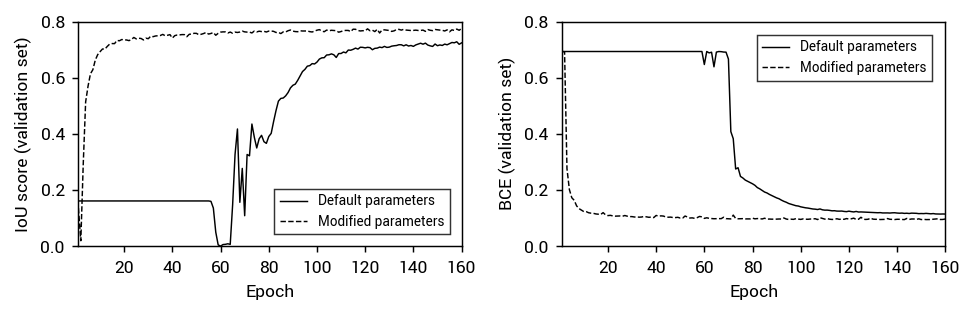

In [ ]:
# mpl.rcParams['font.family'] = 'STIXSizeOneSym'
# plt.rcParams['font.size'] = 12
# plt.rcParams['axes.linewidth'] = 1

fig = plt.figure(0, (6.6, 2.2), dpi=150)
plt.tight_layout(h_pad=5., w_pad=5.)

plt.subplot(121)

# plt.rc('font', family='DejaVu Serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

N_epochs = 160
lw = 0.7

epochs = range(1, N_epochs+1)

# plt.plot(epochs, checkpoint_unmodified_parameters['scores']['train_ious'][:N_epochs], label='Default parameters', color=blue_mod)
plt.plot(epochs, checkpoint_unmodified_parameters['scores']['valid_ious'][:N_epochs], lw=lw, ls='-', label='Default parameters', color='black')
# plt.plot(epochs, checkpoint_modified_parameters['scores']['train_iou'][:N_epochs], label='Modified parameters', color=red_mod)
plt.plot(epochs, checkpoint_modified_parameters['scores']['valid_iou'][:N_epochs], lw=lw, ls='--', label='Modified parameters', color='black')
plt.xlim([1, N_epochs])
plt.ylim([0., 0.8])
plt.xlabel('Epoch')
plt.ylabel('IoU score (validation set)')
plt.tick_params(color='black', length=3)
plt.xticks(np.arange(20., N_epochs+1, 20.))
plt.legend(bbox_to_anchor=(0.494, 0.285), loc='upper left', edgecolor="black", fancybox=False)

plt.subplot(122)
# plt.plot(epochs, checkpoint_unmodified_parameters['scores']['train_bce'][:N_epochs], label='Default parameters', color=blue_mod)
plt.plot(epochs, checkpoint_unmodified_parameters['scores']['valid_bce'][:N_epochs], lw=lw, ls='-', label='Default parameters', color='black')
# plt.plot(epochs, checkpoint_modified_parameters['scores']['train_bce'][:N_epochs], label='Modified parameters', color=red_mod)
plt.plot(epochs, checkpoint_modified_parameters['scores']['valid_bce'][:N_epochs], lw=lw, ls='--', label='Modified parameters', color='black')
plt.xlim([1, N_epochs])
plt.ylim([0., 0.8])
plt.xlabel('Epoch')
plt.ylabel('BCE (validation set)')
plt.tick_params(color='black', length=3)
plt.xticks(np.arange(20., N_epochs+1, 20.))
plt.legend()
plt.legend(bbox_to_anchor=(0.49, 0.97), loc='upper left', edgecolor="black", fancybox=False)
plt.tight_layout()
print(plt.gcf())
plt.savefig('final/plateau_modified_vs_not_modified_parameters.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
from IPython.display import IFrame, display
display(IFrame("./final/plateau_modified_vs_not_modified_parameters.pdf", width=600, height=300))

In [ ]:
checkpoint_unmodified_parameters = load_checkpoint('2020-10-30|00h57_best.dat', save_dir='run_logs/')
# print('Last recorded epoch:', checkpoint['epoch'])
# print(f"Epoch of max validation IoU: {checkpoint['epoch_max_valid_iou']}, with validation IoU of {100*checkpoint['max_valid_iou']:.2f} %; "
#       f"the maximum of the training IoU attained was {100*np.max(checkpoint['scores']['train_iou']):.2f} %")

print()
print(checkpoint['energy_net_config'])
print(checkpoint['dataset_config'])
print(checkpoint['unroll_config'])
print(checkpoint['training_config'])

# testing_config_A = TestingConfig(checkpoint['best_states'][-1], print_results=False, n_trials=100)
testing_config_A = TestingConfig(checkpoint['states'][-1], print_results=False)

print()
ious, mean_ious, std_ious = test_unrolled(testing_config_A, checkpoint)

ious_min_1 = np.min(ious)
ious_max_1 = np.max(ious)
ious_median_1 = np.median(ious)

NameError: ignored

##### IoU Curve for Mixed SPEN vs Mixed Baseline

In [ ]:
checkpoint = load_checkpoint('2020-11-19|19h34.dat', save_dir='run_logs/')

print(checkpoint['energy_net_config'])
print(checkpoint['dataset_config'])
print(checkpoint['unroll_config'])
print(checkpoint['training_config'])

# Número de iterações = 1 com dropout ('2020-10-30|00h43_best)

EnergyNetConfig(n_channels_conv=(120, 140, 180, 220), n_layers_per_conv_block=(2, 2, 3, 3), kernel_sizes=(5, 5, 3, 3), n_linear_features=(200, 80), dropout_probs=(0.3, 0.5), use_batchnorm=False, beta=1.0, last_softplus=False, use_softplus=True)
DatasetConfig(batch_size=48, dataset_mode='mixed', n_visible_letters=None, prob_choice=None, initial_seed=48)
UnrollConfig(n_iter_inference=3, inner_lr=10.0, random_init=False, init_mode='pass', average_of_letter_init=False, entropy_factor=0.0, plot_y=False, plot_hist=False, to_print=False)
TrainingConfig(outer_lr=0.0003, n_epochs=500000, k_patience=50000, saved_checkpoint=None, metrics_names=('bce', 'custom_bce', 'iou'), force_init_zero_validation=True, verbose=False)


In [ ]:
dataset_config_fixed = checkpoint['dataset_config']
dataset_config_fixed = replace(dataset_config_fixed, dataset_mode='fixed')
testing_config_A = TestingConfig(checkpoint['best_states'][-1], print_results=False, n_trials=100)

n_visible_letters_ = range(1, 26)

ious_mean = np.zeros_like(n_visible_letters_, dtype=float)
ious_std = np.zeros_like(n_visible_letters_, dtype=float)
ious_median = np.zeros_like(n_visible_letters_, dtype=float)
ious_min = np.zeros_like(n_visible_letters_, dtype=float)
ious_max = np.zeros_like(n_visible_letters_, dtype=float)
ious_all = []

for idx, n_visible_letters in enumerate(n_visible_letters_):
    print('n_visible_letters:', n_visible_letters)
    dataset_config_fixed = replace(dataset_config_fixed, n_visible_letters=n_visible_letters)
    ious, mean_ious, std_ious = test_unrolled(testing_config_A, dataset_config=dataset_config_fixed,
                                              energy_net_config=checkpoint['energy_net_config'], unroll_config=checkpoint['unroll_config'])
    ious_mean[idx] = 100*np.mean(ious)
    ious_std[idx] = 100*np.std(ious)
    ious_median[idx] = 100*np.median(ious)
    ious_min[idx] = 100*np.min(ious)
    ious_max[idx] = 100*np.max(ious)
    ious_all.append(copy.deepcopy(ious))

n_visible_letters: 1
IoU - Mean: 58.92 • Standard Deviation: 0.70
n_visible_letters: 2
IoU - Mean: 64.67 • Standard Deviation: 0.46
n_visible_letters: 3
IoU - Mean: 67.46 • Standard Deviation: 0.28
n_visible_letters: 4
IoU - Mean: 69.05 • Standard Deviation: 0.22
n_visible_letters: 5
IoU - Mean: 70.06 • Standard Deviation: 0.19
n_visible_letters: 6
IoU - Mean: 70.77 • Standard Deviation: 0.18
n_visible_letters: 7
IoU - Mean: 71.30 • Standard Deviation: 0.18
n_visible_letters: 8
IoU - Mean: 71.69 • Standard Deviation: 0.17
n_visible_letters: 9
IoU - Mean: 72.01 • Standard Deviation: 0.19
n_visible_letters: 10
IoU - Mean: 72.26 • Standard Deviation: 0.21
n_visible_letters: 11
IoU - Mean: 72.48 • Standard Deviation: 0.21
n_visible_letters: 12
IoU - Mean: 72.67 • Standard Deviation: 0.23
n_visible_letters: 13
IoU - Mean: 72.85 • Standard Deviation: 0.25
n_visible_letters: 14
IoU - Mean: 72.99 • Standard Deviation: 0.26
n_visible_letters: 15
IoU - Mean: 73.12 • Standard Deviation: 0.27
n_vi

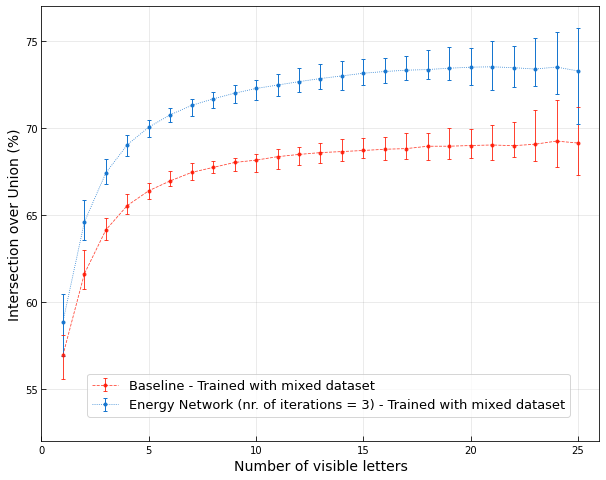

In [ ]:
plt.figure(0, (10, 8))
ax = plt.subplot(111)
# before it used , fmt='.k'

plt.errorbar(n_visible_letters_, chkp_m['ious_median'], elinewidth=1, linewidth=0.8, yerr=error_bars_m, color='#ff1500',
             ls='--', fmt='.', ecolor='#ff1500', capsize=2, alpha=0.8, label='Baseline - Trained with mixed dataset'); # red
plt.errorbar(n_visible_letters_, ious_median, elinewidth=1, linewidth=0.8, yerr=error_bars, color='#1776cf',
             ecolor='#1776cf', fmt='.', ls=':', capsize=2, alpha=1, label='Energy Network (nr. of iterations = 3) - Trained with mixed dataset');  # blue
plt.xlabel('Number of visible letters', fontsize=14)
plt.ylabel('Intersection over Union (%)', fontsize=14)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.xlim([0, 26])
plt.ylim([52, 77])
plt.legend(fontsize=13, bbox_to_anchor=(0.07, 0.17), loc='upper left')
# plt.tick_params(which='both', top='off', left='off', right='off',  bottom='off') # turn off bottom ticks
# plt.set_major_locator(MultipleLocator(1))
plt.tick_params(direction='in', color='black', length=5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.savefig('final/energy_net_vs_baseline_mixed_iou.pdf', format='pdf', bbox_inches='tight')

In [ ]:
ious_min_f = 100*np.array([ious_min_1, ious_min_11, ious_min_21])
ious_max_f = 100*np.array([ious_max_1, ious_max_11, ious_max_21])
ious_median_f = 100*np.array([ious_median_1, ious_median_11, ious_median_21])
ious_min_max_f = np.vstack([ious_min, ious_max])
error_bars_f = abs(ious_min_max-ious_median)

In [ ]:
chkp_m = load_checkpoint('parameters_and_ious_spens_mixed.dat', save_dir='final/')
ious_min_max_m = np.vstack([chkp_m['ious_min'], chkp_m['ious_max']])
error_bars_m = abs(ious_min_max_m - chkp_m['ious_median'])

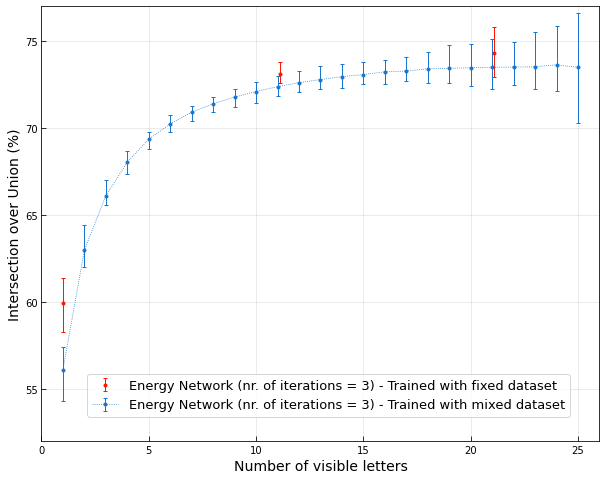

In [ ]:
plt.figure(0, (10, 8))
ax = plt.subplot(111)
# before it used , fmt='.k'

plt.errorbar([1, 11.1, 21.1], ious_median_f, elinewidth=1, linewidth=0.8, yerr=error_bars_f, color='#ff1500',
             ecolor='#ff1500', fmt='.', ls=None, capsize=2, alpha=1, label='Energy Network (nr. of iterations = 3) - Trained with fixed dataset');  # blue
plt.errorbar(n_visible_letters_, chkp_m['ious_median'], elinewidth=1, linewidth=0.8, yerr=error_bars_m, color='#1776cf',
             ecolor='#1776cf', fmt='.', ls=':', capsize=2, alpha=1, label='Energy Network (nr. of iterations = 3) - Trained with mixed dataset');  # blue
plt.xlabel('Number of visible letters', fontsize=14)
plt.ylabel('Intersection over Union (%)', fontsize=14)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', alpha=0.3, color='gray')
plt.xlim([0, 26])
plt.ylim([52, 77])
plt.legend(fontsize=13, bbox_to_anchor=(0.07, 0.17), loc='upper left')
# plt.tick_params(which='both', top='off', left='off', right='off',  bottom='off') # turn off bottom ticks
# plt.set_major_locator(MultipleLocator(1))
plt.tick_params(direction='in', color='black', length=5)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
plt.savefig('final/energy_net_mixed_vs_fixed_iou.pdf', format='pdf', bbox_inches='tight')

## Others

### Plots

In [ ]:

f
plt.savefig('final/plateau_modified_vs_not_modified_parameters.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
softplus_1 = nn.Softplus(1)
softplus_25 = nn.Softplus(25)
relu = nn.ReLU()

In [ ]:
class SigmoidBeta(nn.Module):
    def __init__(self, beta):
        super(SigmoidBeta, self).__init__()
        self.beta = beta
    def forward(self, x):
        return torch.sigmoid(self.beta*x)

class DSigmoidBeta(nn.Module):
    def __init__(self, beta):
        super(DSigmoidBeta, self).__init__()
        self.beta = beta
        self.sigmoid = SigmoidBeta(beta)
    def forward(self, x):
        return self.beta*self.sigmoid(x)*(1-self.sigmoid(x))

In [ ]:
dsigmoid_1 = DSigmoidBeta(1.)
dsigmoid_25 = DSigmoidBeta(25.)

print(dsigmoid_25(xrange))

tensor([4.8219e-21, 4.8315e-21, 4.8412e-21,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00], dtype=torch.float64)


In [ ]:
mpl.rcParams['axes.linewidth'] = 0.7 #set the value globally
mpl.rcParams['xtick.major.width'] = 0.7
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.7
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['legend.fontsize'] = 7.5
mpl.rcParams['patch.linewidth'] = 0.7
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.alpha'] = 0.5
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'

blue_mod_2 = '#308fe8'

NameError: ignored

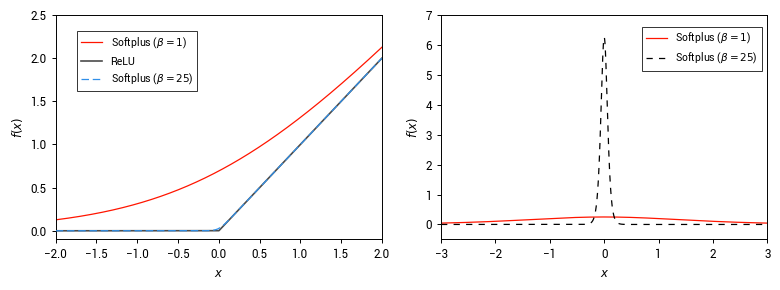

In [ ]:
# mpl.rcParams['font.family'] = 'STIXSizeOneSym'
# plt.rcParams['font.size'] = 12
# plt.rcParams['axes.linewidth'] = 1

# fig = plt.figure(0, (6.6, 2.4), dpi=100)
plt.figure(0, (8., 3), dpi=100)

ax = plt.subplot(121)
ax.set_alpha(0.5)
# plt.rc('font', family='DejaVu Serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

lw = 0.9

xrange = torch.tensor(np.linspace(-2., 2, 50001))

plt.plot(xrange, softplus_1(xrange), lw=lw, ls='-', color=red_mod, label='Softplus ($\\beta = 1$)')
plt.plot(xrange, relu(xrange), lw=lw+0.3, ls='-', color=blue_mod, label='ReLU', alpha=0.7, zorder=99)
plt.plot(xrange, softplus_25(xrange), lw=lw, ls='--', dashes=[6, 3], color=blue_mod_2, label='Softplus ($\\beta = 25$)', alpha=1., zorder=100)

# plt.xlim([1, N_epochs])
plt.xlim([-2, 2])
plt.ylim([-0.1, 2.5])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.xlabel('Epoch')
# plt.ylabel('IoU score (validation set)')
plt.tick_params(color='black', length=3)
# plt.xticks(np.arange(20., N_epochs+1, 20.))
plt.legend(bbox_to_anchor=(0.05, 0.95), loc='upper left', edgecolor="black", fancybox=False)

plt.subplot(122)

xrange = torch.tensor(np.linspace(-3., 3, 50001))
plt.plot(xrange, dsigmoid_1(xrange), lw=lw, ls='-', color=red_mod, label='Softplus ($\\beta = 1$)')
plt.plot(xrange, dsigmoid_25(xrange), lw=lw, ls='--', dashes=[5, 5], color=blue_mod, label='Softplus ($\\beta = 25$)')
# plt.xlim([1, N_epochs])
plt.xlim([-3, 3])
plt.ylim([-0.5, 7])
plt.xlabel('$x$')
plt.ylabel('$f\'\'(x)$')
plt.tick_params(color='black', length=3)
plt.legend(bbox_to_anchor=(0.6, 0.97), loc='upper left', edgecolor="black", fancybox=False)
plt.tight_layout()

plt.savefig('final/softplus.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Test IoU using just average of each letter

In [ ]:
checkpoint = load_checkpoint('2020-10-30|00h43_best.dat', save_dir='run_logs/')


In [ ]:
best_average_iou = 0.

for threshold in np.linspace(0, 1, 101):

    sum_iou = 0

    for i, x in enumerate(valid_data.iterrows()):
        x = torch.tensor(x[1]).squeeze()
        # plot_font(x.cpu().detach())
        iou_ = iou(x, discretize(average_of_letter[0], threshold))
        # print(f'{100*iou_:.2f} %')
        sum_iou += iou_

    average_iou = sum_iou / len(test_data)
    print(f'Threshold: {threshold:.2f} - Average IoU: {100*average_iou:.2f} %')

    if average_iou > best_average_iou:
        best_average_iou = average_iou
        best_threshold = threshold

print()
print(f'O melhor threshold foi {best_threshold} e a melhor média dos IoU no valid dataset '
      f'entre as fontes e a média de cada caractér é {100*best_average_iou:.2f} %')

Threshold: 0.00 - Average IoU: 16.02 %
Threshold: 0.01 - Average IoU: 22.58 %
Threshold: 0.02 - Average IoU: 24.89 %
Threshold: 0.03 - Average IoU: 26.33 %
Threshold: 0.04 - Average IoU: 27.64 %
Threshold: 0.05 - Average IoU: 28.57 %
Threshold: 0.06 - Average IoU: 29.50 %
Threshold: 0.07 - Average IoU: 30.37 %
Threshold: 0.08 - Average IoU: 31.20 %
Threshold: 0.09 - Average IoU: 31.84 %
Threshold: 0.10 - Average IoU: 32.57 %
Threshold: 0.11 - Average IoU: 33.17 %
Threshold: 0.12 - Average IoU: 33.69 %
Threshold: 0.13 - Average IoU: 34.30 %
Threshold: 0.14 - Average IoU: 34.71 %
Threshold: 0.15 - Average IoU: 35.13 %
Threshold: 0.16 - Average IoU: 35.52 %
Threshold: 0.17 - Average IoU: 35.91 %
Threshold: 0.18 - Average IoU: 36.26 %
Threshold: 0.19 - Average IoU: 36.56 %
Threshold: 0.20 - Average IoU: 36.76 %
Threshold: 0.21 - Average IoU: 36.98 %
Threshold: 0.22 - Average IoU: 37.16 %
Threshold: 0.23 - Average IoU: 37.29 %
Threshold: 0.24 - Average IoU: 37.41 %
Threshold: 0.25 - Average

### Graph

In [ ]:
# init_ious_directly_zero = pickle_load('init_ious_dict_directly_0.dat')

with open('/content/drive/My Drive/thesis1/pickle/1.1/init_ious_dict_approppriate.dat', 'rb') as f:
    init_ious_appropriate = pickle.load(f)
# init_ious_appropriate = pickle_load('/content/drive/My Drive/thesis1/pickle/1.1/init_ious_dict_approppriate.dat')
# unrolled_ious_directly_zero = pickle_load('unrolled_test_ious_directly_0.dat')

In [ ]:
l = []
for k in globals().keys():
    l.append(k)
l.sort()

pprint(l)

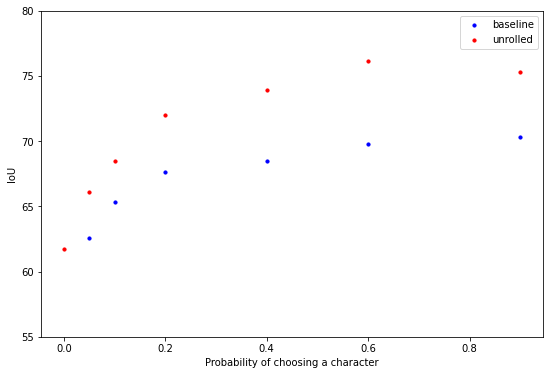

In [ ]:
# for i, (p, v) in enumerate(init_ious_directly_zero.items()):
#     if i == 0:
#         plt.scatter(p, v, color='black', s=10, label='baseline, trained for p=0')
#     else:
#         plt.scatter(p, v, color='black', s=10)
for i, (p, v) in enumerate(init_ious_appropriate.items()):
    if i == 0:
        plt.scatter(p, v, color='blue', s=10, label='baseline')
    else:
        plt.scatter(p, v, color='blue', s=10)
for i, (p, v) in enumerate(test_ious_unrolled.items()):
    if i == 0:
        plt.scatter(p, v, color='red', s=10, label='unrolled')
    else:
        plt.scatter(p, v, color='red', s=10)
plt.legend()
plt.xlabel('Probability of choosing a character')
plt.ylabel('IoU')
plt.ylim([55, 80])
plt.show()

In [ ]:
res_iou_directly_zero_init_zero = {'probs_choice':probs_choice_, 'test_ious':test_ious_init_0}
pickle_dump(res_iou_directly_zero_init_zero, 'res_iou_directly_zero_init_zero.dat')

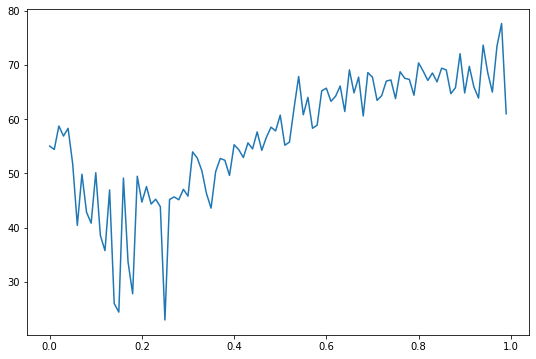

In [ ]:
plt.plot(probs_choice_, test_ious_init_0)